In [1]:
import bambi as bmb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
from collections import defaultdict
from IPython.display import display
from scipy import stats
import pymc as py
import arviz as az
import json
from scikit_posthocs import posthoc_dunn
from itertools import combinations



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#inverted , which is needed for some of the presence quetsionaires ( 8-, since  a likert scale of 7 was used)
def invert(d):
    return 8-d
computer = "C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis"
#computer = "C:/Users/LauflaborVR2/GS-MT_Test"
soci_data = pd.read_csv(computer +"/Data/main_presence_questionaire.csv")
heights = soci_data["Height"]
weights = soci_data["Weight"]
demographic_labels = ["Gender", "Age", "Height", "Weight"]
vr_labels = ["VR Experience","VR Usage","First Person Video Games", "Motion Sickness"]
demo_data = soci_data[demographic_labels]
vr_data = soci_data[vr_labels]
vr_exps = vr_data["VR Experience"]* (-1) +2
ipq_data = soci_data.drop(demographic_labels + vr_labels, axis= 1)
ipq11 = ipq_data.drop( "VPID", axis=1)
ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]]= ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]].map(invert)
ipq_means = ipq11.mean(axis=1)


In [3]:
with open('combined_step_analysis_results_with_arrays.json', 'r') as file:
    data = json.load(file)

# Flatten JSON into a structured DataFrame
flat_data = []

for participant, conditions in data.items():
    for condition, trials in conditions.items():
        for trial, metrics in trials.items():
            # Extract only the required scalar value for velocity (assuming velocity_mean_l is a float, not a list)
            if isinstance(metrics["mean_velocity"], list):
                # If velocity_mean_l is somehow a list, take the mean or handle appropriately
                velocity = sum(metrics["mean_velocity"]) / len(metrics["mean_velocity"])
            else:
                velocity = metrics["mean_velocity"]
            row = {
                "Participant": participant,
                "Condition": condition,
                "Trial": trial,
                "Velocity": velocity, 
                "numStrides_r": metrics["numStrides_r"],
                "numStrides_l": metrics["numStrides_l"],
                "Walking_distance": metrics["walking_distance_r"],
                "HeelR_velocity": metrics["HeelR_velocity"],
                "HeelL_velocity": metrics["HeelL_velocity"],
                "strideLength_r": metrics["meanstrideLength_r"],
                "strideLength_l": metrics["meanstrideLength_l"],
                "RoM_ankle_l": metrics["footAngle_l"],
                "RoM_knee_l": metrics["kneeAngle_l"],
                "RoM_ankle_r": metrics["footAngle_r"],
                "RoM_knee_r": metrics["kneeAngle_r"],

            }
            flat_data.append(row)

# Create a pandas DataFrame
df = pd.DataFrame(flat_data)

df['Participant'] = df['Participant'].str.extract('(\d+)').astype(int)
df['Condition'] = df['Condition'].str.extract('(\d+)').astype(int)
df['Trial'] = df['Trial'].str.extract('(\d+)').astype(int)
# Convert categorical variables
df['Participant'] = df['Participant'].astype('category')
df['Condition'] = df['Condition'].astype('category')

#normalize velocity
velocity_min = df['Velocity'].min()
velocity_max = df['Velocity'].max()

# Min-Max Normalisierung der Velocity-Daten
df['Velocity_normalized'] = (df['Velocity'] - velocity_min) / (velocity_max - velocity_min)

unique_participants = df['Participant'].unique()
participant_height_dict = dict(zip(unique_participants, heights))
df["Height"] = df["Participant"].map(participant_height_dict)
participant_weight_dict = dict(zip(unique_participants, weights))
df["Weight"] = df["Participant"].map(participant_weight_dict)
participant_presence_dict = dict(zip(unique_participants, ipq_means))
df['Presence'] = df['Participant'].map(participant_presence_dict)
participant_experience_dict = dict(zip(unique_participants, vr_exps))
df["VR_Experience"] = df["Participant"].map(participant_experience_dict)

embodi_data = {}
condition_names =["Baseline", "Large", "NoAvatar", "Normal", "Small"]
for c in df['Condition'].unique():
    if c== 0:
        continue

    temp = {}
    cond = condition_names[c-1]
    for p in df['Participant'].unique():
        if p< 10:
            file_path = computer + f"/Data/0{p}{cond}.csv"
        else:
             file_path =  computer + f"/Data/{p}{cond}.csv"
        try:
            d = pd.read_csv(file_path, names=["Question", "Value"])
            temp[p] = d
        except FileNotFoundError:
            print(f"Datei nicht gefunden: {file_path}")
    embodi_data[c] = temp

# alles auf meter (pro sekunde) bringen 
df['Height'] = df['Height']/100
df['Velocity'] = df['Velocity']/1000
df["Walking_distance"] = df["Walking_distance"]/1000
df["HeelR_velocity"] = df["HeelR_velocity"]/1000
df["HeelL_velocity"] = df["HeelL_velocity"]/1000
df["strideLength_l"] = df["strideLength_l"]/1000
df["strideLength_r"] = df["strideLength_r"]/1000
df["RoM_ankle_l"] = df["RoM_ankle_l"].apply(np.mean)
df["RoM_ankle_r"] = df["RoM_ankle_r"].apply(np.mean)
df["RoM_knee_l"] = df["RoM_knee_l"].apply(np.mean)
df["RoM_knee_r"] = df["RoM_knee_r"].apply(np.mean)

# Fragebogendaten dem DataFrame df hinzufügen
question_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']

for index, row in df.iterrows():
    participant = row['Participant']
    condition = row['Condition']

    # Fragebogendaten nur hinzufügen, wenn es sich nicht um die Baseline-Bedingung handelt
    if condition != 0 and condition in embodi_data and participant in embodi_data[condition]:
        survey_data = embodi_data[condition][participant]
        # Berechnung der Mittelwerte für "Ownership", "Agency" und "Change"
        ownership_mean = survey_data['Value'].iloc[:4].mean()
        agency_mean = survey_data['Value'].iloc[4:8].mean()
        change_mean = survey_data['Value'].iloc[8:12].mean()
        embodi_mean = survey_data["Value"].iloc[:12].mean()
        # Mittelwerte dem DataFrame hinzufügen
        df.at[index, 'Ownership'] = ownership_mean
        df.at[index, 'Agency'] = agency_mean
        df.at[index, 'Change'] = change_mean
        df.at[index, "Embdodiment"] = embodi_mean

df['Ownership'] = df['Ownership'].astype('category')
df['Agency'] = df['Agency'].astype('category')
df['Change'] = df['Change'].astype('category')
df['Embdodiment'] = df['Embdodiment'].astype('category')




Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/08Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/09Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/10Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/11Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/12Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/13Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/14Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/15Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/16Baseline.csv
Datei nicht gefunden: C:/Users/grego/

In [15]:
df.describe().loc[["mean", "std"]]

Trial  Velocity  numStrides_r  numStrides_l  Walking_distance  \
mean  5.200893  0.530604      2.098214      2.426339          3.134063   
std   2.850456  0.122967      0.427465      0.504053          0.360894   

      HeelR_velocity  HeelL_velocity  strideLength_r  strideLength_l  \
mean        0.645635        0.649257        1.110936        1.123828   
std         0.169719        0.165045        0.145788        0.118764   

      RoM_ankle_l  RoM_knee_l  RoM_ankle_r  RoM_knee_r  Velocity_normalized  \
mean    54.682714   40.364492     59.75616   39.319458             0.377035   
std      4.767657    4.775451      5.69827    6.846308             0.209419   

        Height     Weight  Presence  VR_Experience  
mean  1.822902  76.203125  4.045121       0.500000  
std   0.052316  12.052320  0.441871       0.500559

## Deskriptive analysis

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\27799474.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Velocity', data=df, palette='Set1')


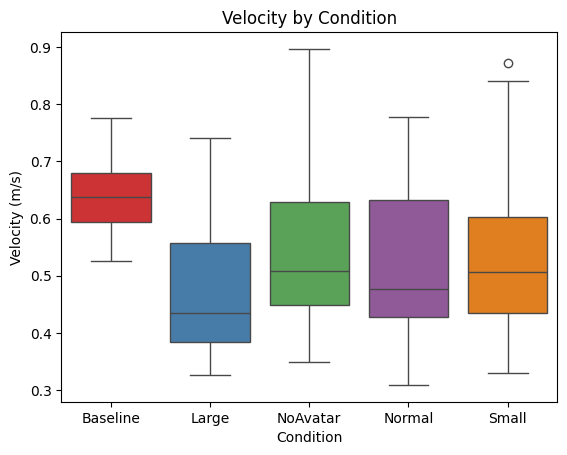

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\27799474.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Condition", y="Velocity", data=df, inner="quartile", palette='Set1')


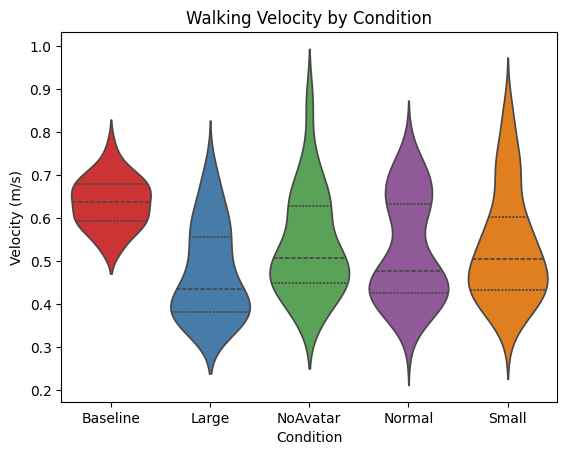

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\27799474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='stride_mean', data=df, inner = "quartile", palette='Set1')


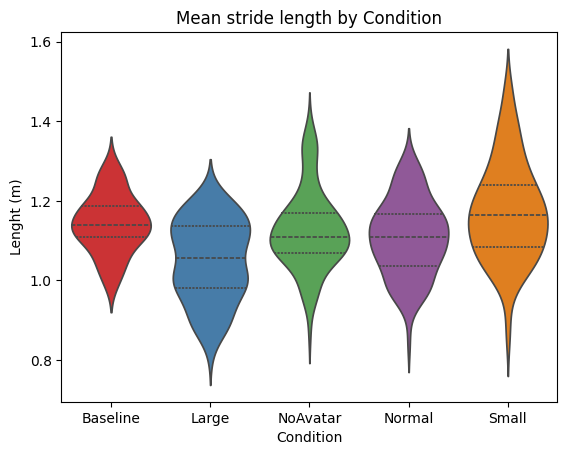

In [9]:
sns.boxplot(x='Condition', y='Velocity', data=df, palette='Set1')
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Velocity by Condition')
plt.xlabel('Condition')
plt.ylabel('Velocity (m/s)')
plt.show()

sns.violinplot(x="Condition", y="Velocity", data=df, inner="quartile", palette='Set1')
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title("Walking Velocity by Condition")
plt.xlabel("Condition")
plt.ylabel("Velocity (m/s)")
plt.show()

"""sns.boxplot(x='Condition', y='HeelR_velocity', data=df, color= "r")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Right Heel Velocity by Condition')
plt.xlabel('Condition')
plt.ylabel('Velocity (m/s)')
plt.show()"""

"""sns.boxplot(x='Condition', y='HeelL_velocity', data=df, color= "r")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Left Heel Velocity by Condition')
plt.xlabel('Condition')
plt.ylabel('Velocity (m/s)')
plt.show()"""

sns.violinplot(x='Condition', y='stride_mean', data=df, inner = "quartile", palette='Set1')
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Mean stride length by Condition')
plt.xlabel('Condition')
plt.ylabel('Lenght (m)')
plt.show()

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\1568327808.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Walking_distance', data=df, palette= "Set1")


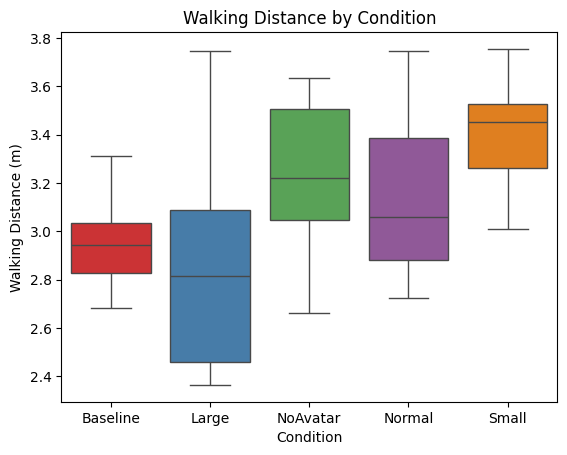

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\1568327808.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='Walking_distance', data=df, inner= "quartile", palette= "Set1")


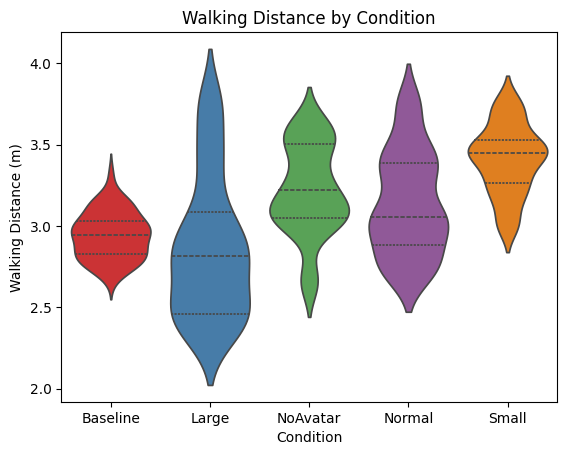

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\1568327808.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='RoM_ankle_l', data=df, inner= "quartile", palette= "Set1")


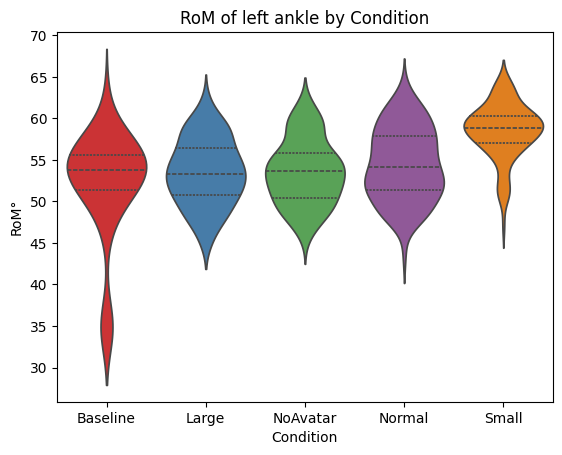

C:\Users\grego\AppData\Local\Temp\ipykernel_2580\1568327808.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='RoM_ankle_r', data=df, inner= "quartile", palette= "Set1")


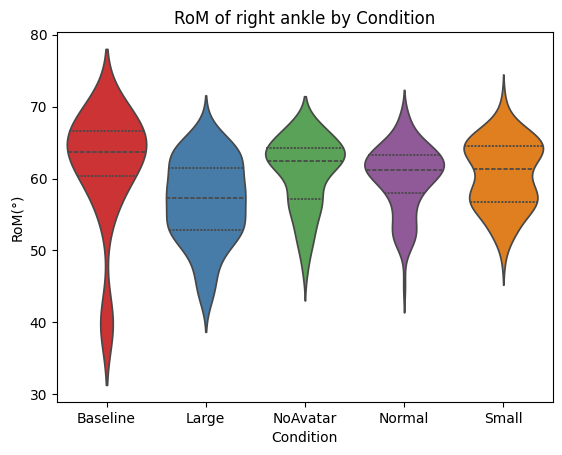

In [8]:
sns.boxplot(x='Condition', y='Walking_distance', data=df, palette= "Set1")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Walking Distance by Condition')
plt.xlabel('Condition')
plt.ylabel('Walking Distance (m)')
plt.show()
sns.violinplot(x='Condition', y='Walking_distance', data=df, inner= "quartile", palette= "Set1")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Walking Distance by Condition')
plt.xlabel('Condition')
plt.ylabel('Walking Distance (m)')
plt.show()
sns.violinplot(x='Condition', y='RoM_ankle_l', data=df, inner= "quartile", palette= "Set1")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('RoM of left ankle by Condition')
plt.xlabel('Condition')
plt.ylabel('RoM°')
plt.show()
sns.violinplot(x='Condition', y='RoM_ankle_r', data=df, inner= "quartile", palette= "Set1")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('RoM of right ankle by Condition')
plt.xlabel('Condition')
plt.ylabel('RoM(°)')
plt.show()

In [36]:
# Normalverteilung prüfen
stat, p_value = stats.shapiro(df["RoM_ankle_l"] )
print("Shapiro-Wilk-Test:", "p-Wert =", p_value)
#nicht normalverteilt

Shapiro-Wilk-Test: p-Wert = 1.0762425915895363e-09


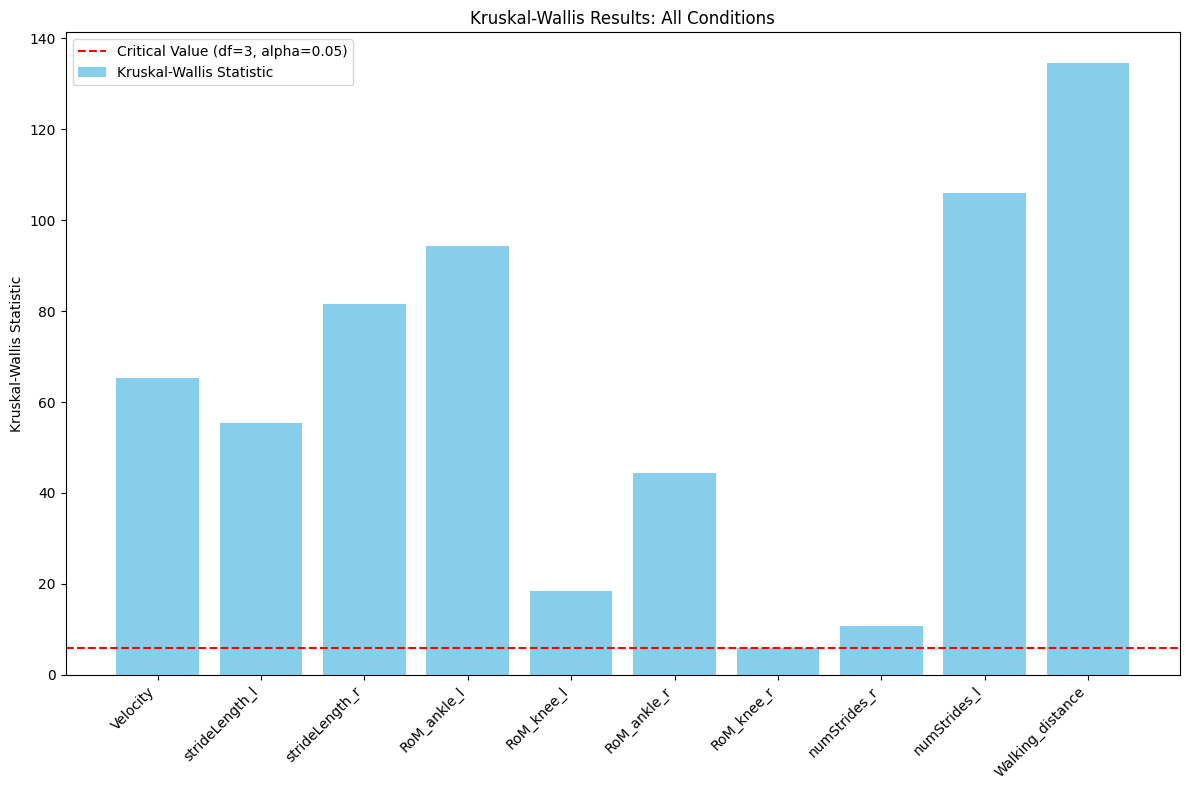

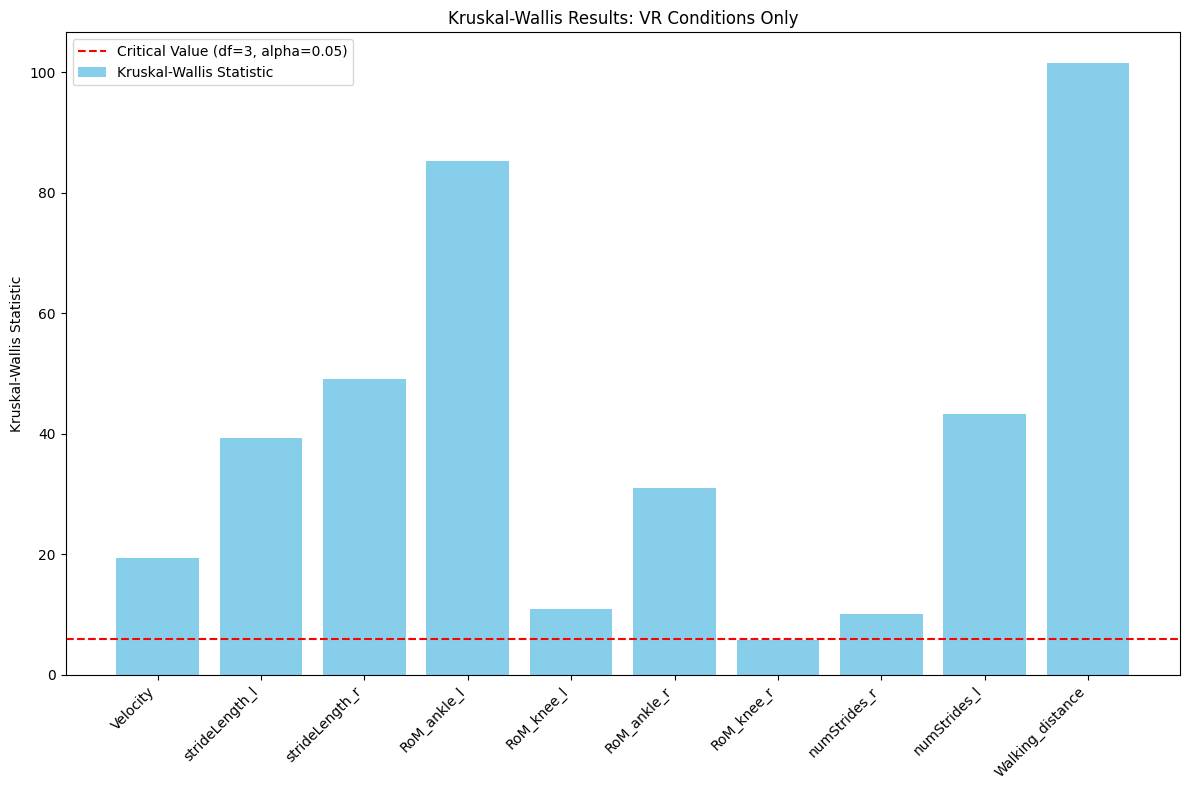

In [4]:
# Define the parameters to test
test_parameters = [
    'Velocity', 'strideLength_l', 'strideLength_r', 'RoM_ankle_l', 'RoM_knee_l',
    'RoM_ankle_r', 'RoM_knee_r', 'numStrides_r', 'numStrides_l', 'Walking_distance'
]

# Initialize results for Kruskal-Wallis tests
kruskal_results_all_conditions = {}
kruskal_results_vr_conditions = {}

# Filter VR conditions only (2: Large, 3: NoAvatar, 4: Normal, 5: Small)
vr_conditions = [2, 3, 4, 5]
vr_data = df[df['Condition'].isin(vr_conditions)]

# Perform Kruskal-Wallis tests for all conditions
for param in test_parameters:
    # Test across all conditions
    groups_all = [df[df['Condition'] == cond][param].dropna() 
                  for cond in df['Condition'].unique()]
    stat_all, p_all = stats.kruskal(*groups_all)
    kruskal_results_all_conditions[param] = {'Statistic': stat_all, 'P-Value': p_all}
    
    # Test across VR conditions only
    groups_vr = [vr_data[vr_data['Condition'] == cond][param].dropna() for cond in vr_conditions]
    stat_vr, p_vr = stats.kruskal(*groups_vr)
    kruskal_results_vr_conditions[param] = {'Statistic': stat_vr, 'P-Value': p_vr}

# Convert results to DataFrames
results_all_conditions_df = pd.DataFrame.from_dict(kruskal_results_all_conditions, orient='index')
results_vr_conditions_df = pd.DataFrame.from_dict(kruskal_results_vr_conditions, orient='index')

# Include 'RoM_knee_l' back into the filtered parameters
test_parameters_with_knee = test_parameters

# Recompute results for all conditions and VR conditions
results_all_conditions_with_knee = results_all_conditions_df.loc[test_parameters_with_knee]
results_vr_conditions_with_knee = results_vr_conditions_df.loc[test_parameters_with_knee]

def plot_kruskal_results(results_df, title):
    plt.figure(figsize=(12, 8))
    x = np.arange(len(results_df.index))
    plt.bar(x, results_df['Statistic'], color='skyblue', label='Kruskal-Wallis Statistic')
    plt.xticks(x, results_df.index, rotation=45, ha='right')
    plt.axhline(y=5.99, color='red', linestyle='--', label='Critical Value (df=3, alpha=0.05)')
    plt.ylabel('Kruskal-Wallis Statistic')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot results for all conditions
plot_kruskal_results(results_all_conditions_with_knee, "Kruskal-Wallis Results: All Conditions")

# Plot results for VR conditions only
plot_kruskal_results(results_vr_conditions_with_knee, "Kruskal-Wallis Results: VR Conditions Only")


In [7]:
baseline_condition = 1  # Baseline condition identifier
percentage_deviation_results = {}
conditions2 = df['Condition'].unique()
condition_pairs = list(combinations(conditions2, 2))


# Loop through each parameter and calculate percentage deviation
for param in test_parameters:
    deviations = []
    conditions = []
    participants = []

    for condition in df['Condition'].unique():
        if condition == baseline_condition:
            continue  # Skip baseline itself
        
        # Extract data for the current condition and baseline
        condition_data = df[df['Condition'] == condition]
        baseline_data = df[df['Condition'] == baseline_condition]
        
        # Align participants to ensure matching
        common_participants = condition_data['Participant'].isin(baseline_data['Participant'])
        condition_data = condition_data[common_participants]
        baseline_data = baseline_data[baseline_data['Participant'].isin(condition_data['Participant'])]
        
        # Calculate percentage deviation
        for participant in condition_data['Participant'].unique():
            cond_mean = condition_data[condition_data['Participant'] == participant][param].mean()
            baseline_mean = baseline_data[baseline_data['Participant'] == participant][param].mean()
            
            if pd.notnull(baseline_mean) and baseline_mean != 0:  # Avoid division by zero
                deviation = ((cond_mean - baseline_mean) / baseline_mean) * 100
                deviations.append(deviation)
                conditions.append(condition)
                participants.append(participant)
    
    # Store deviations in the results dictionary
    percentage_deviation_results[param] = pd.DataFrame({
        'Participant': participants,
        'Condition': conditions,
        'Percentage Deviation': deviations
    })

# Combine all deviations into one DataFrame for further analysis
combined_deviation_df = pd.concat(percentage_deviation_results.values(), keys=percentage_deviation_results.keys(), names=['Parameter'])

# Perform Kruskal-Wallis and Mann-Whitney tests
kruskal_results_percentage = {}
mann_whitney_results_percentage = {param: [] for param in test_parameters}

# Kruskal-Wallis tests
for param, deviation_df in percentage_deviation_results.items():
    groups = [deviation_df[deviation_df['Condition'] == cond]['Percentage Deviation'].dropna() 
              for cond in deviation_df['Condition'].unique()]
    stat, p_value = stats.kruskal(*groups)
    eta_squared = stat / (len(deviation_df) - 1)
    kruskal_results_percentage[param] = {
        'Statistic': stat,
        'P-Value': p_value,
        'Effect Size (eta^2)': eta_squared
    }

# Mann-Whitney U tests
for param, deviation_df in percentage_deviation_results.items():
    condition_pairs = list(combinations(deviation_df['Condition'].unique(), 2))
    for cond1, cond2 in condition_pairs:
        group1 = deviation_df[deviation_df['Condition'] == cond1]['Percentage Deviation'].dropna()
        group2 = deviation_df[deviation_df['Condition'] == cond2]['Percentage Deviation'].dropna()
        
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            r = stats.norm.ppf(1 - p_value / 2) / np.sqrt(len(group1) + len(group2))  # Effect size (r)
            mann_whitney_results_percentage[param].append({
                'Condition1': cond1,
                'Condition2': cond2,
                'Statistic': stat,
                'P-Value': p_value,
                'Effect Size (r)': r
            })

# Convert results to DataFrames
kruskal_results_percentage_df = pd.DataFrame.from_dict(kruskal_results_percentage, orient='index')
mann_whitney_results_percentage_df = pd.concat({
    param: pd.DataFrame(results) for param, results in mann_whitney_results_percentage.items()
}, axis=0).reset_index(level=0).rename(columns={'level_0': 'Parameter'})



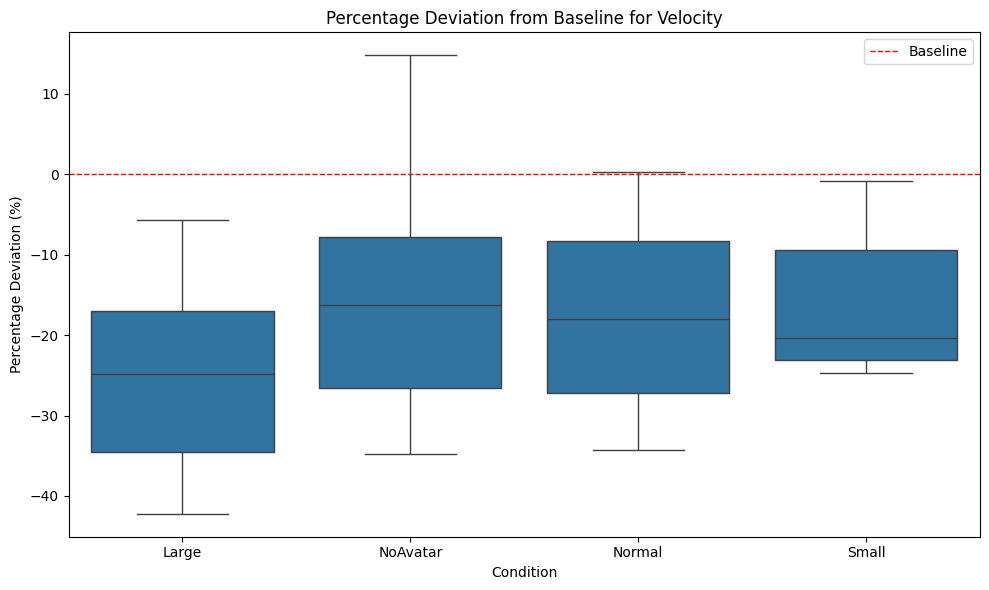

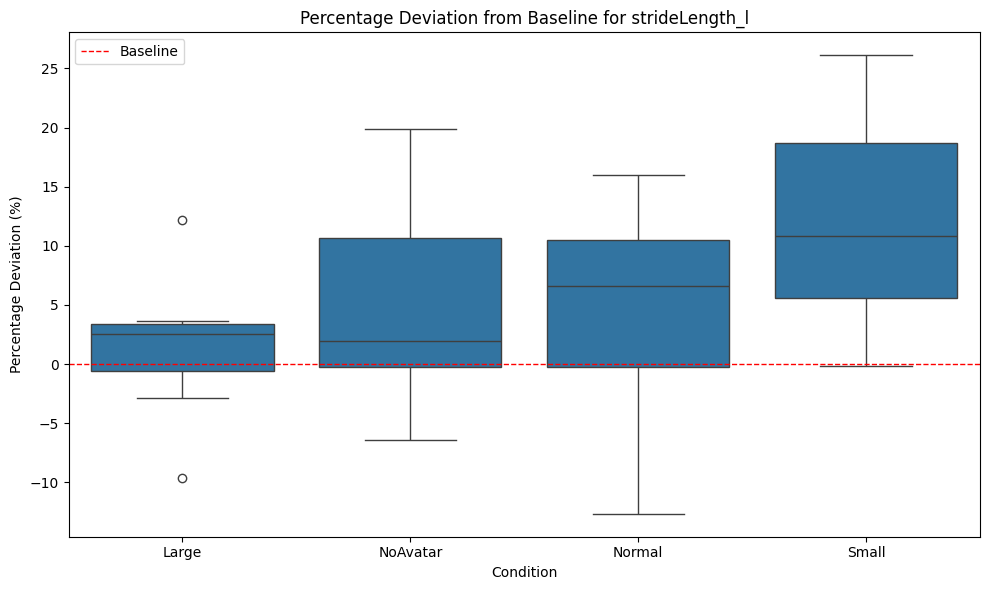

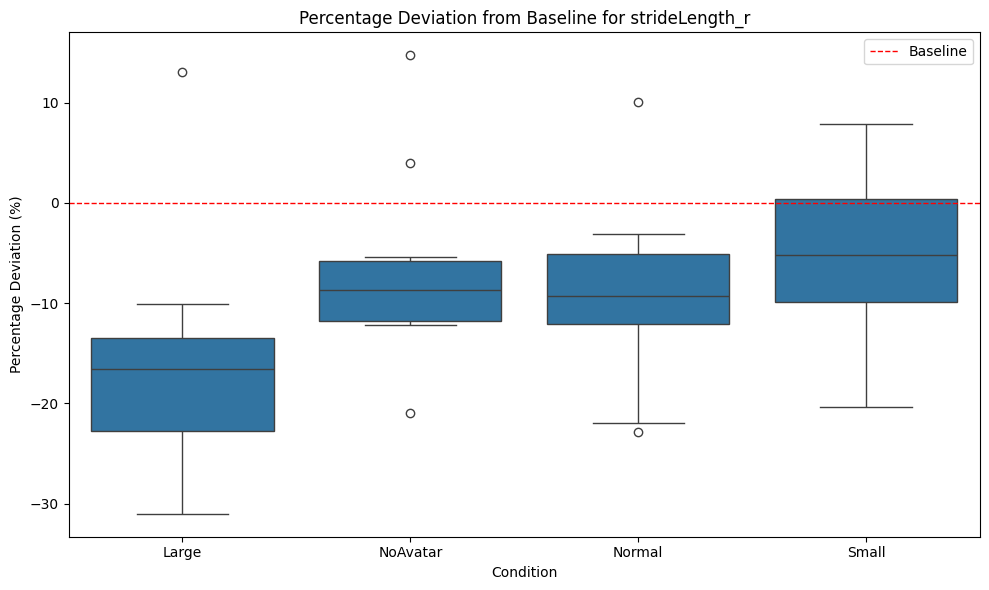

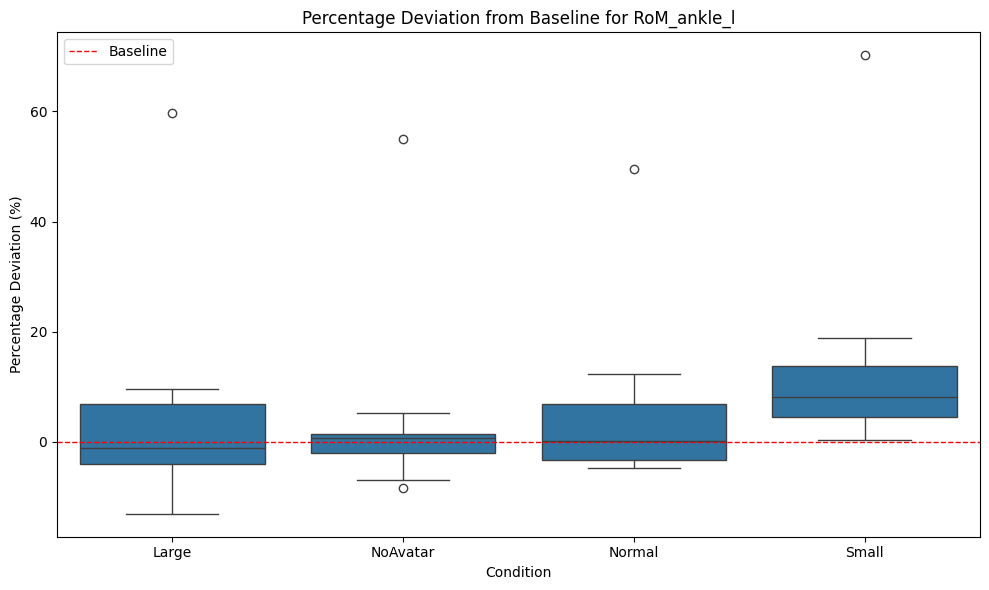

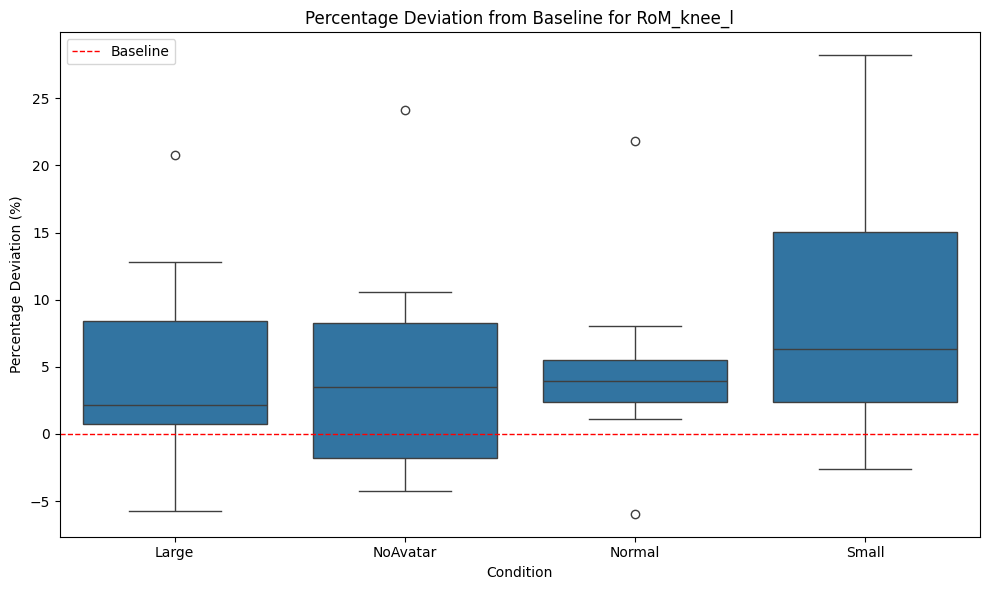

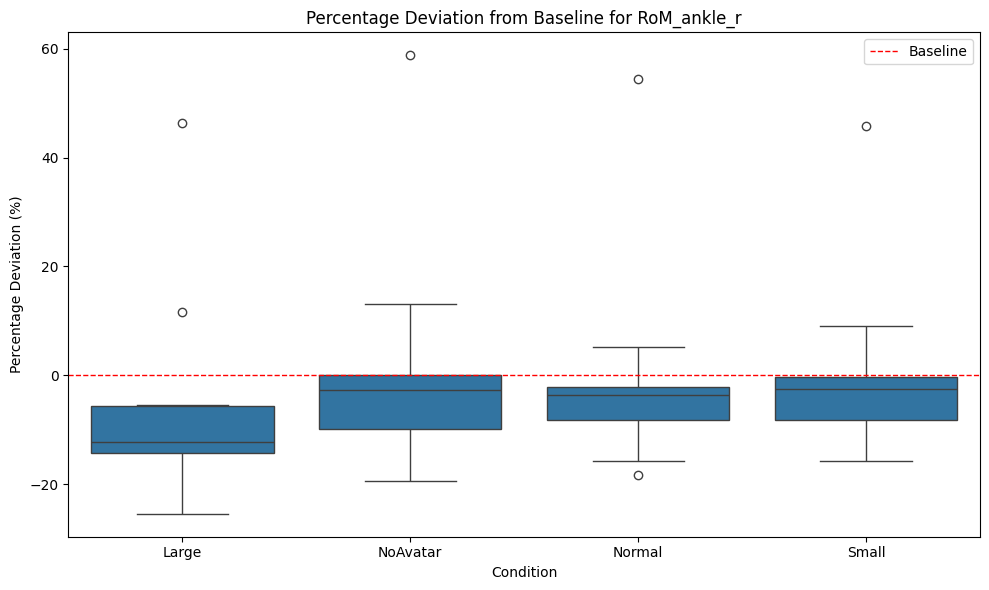

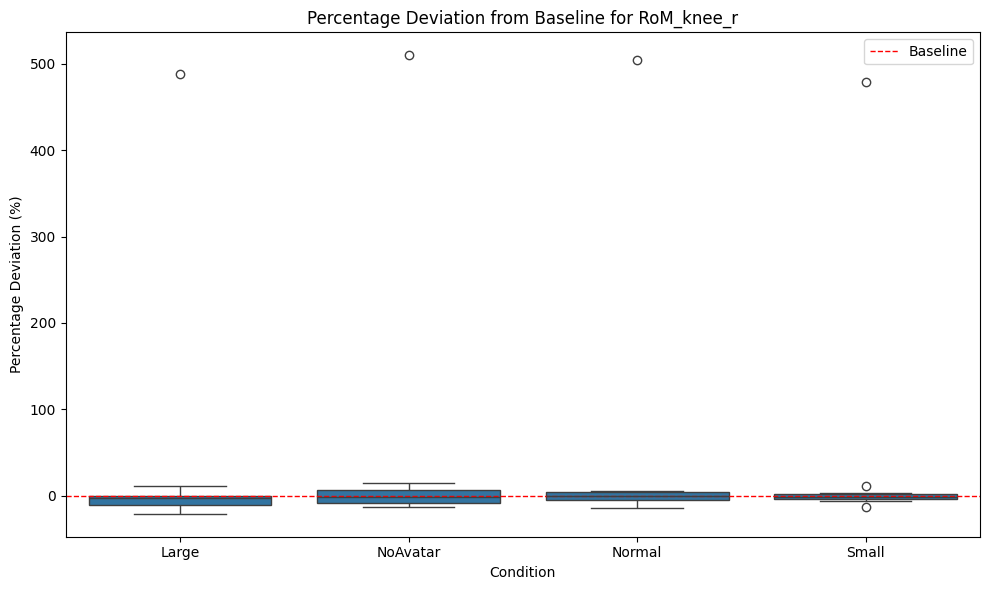

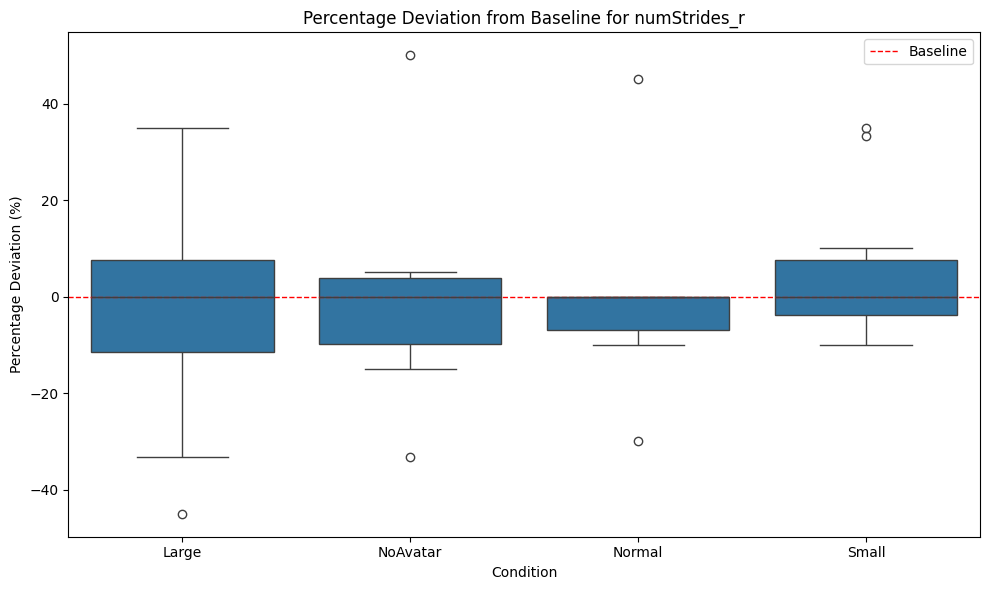

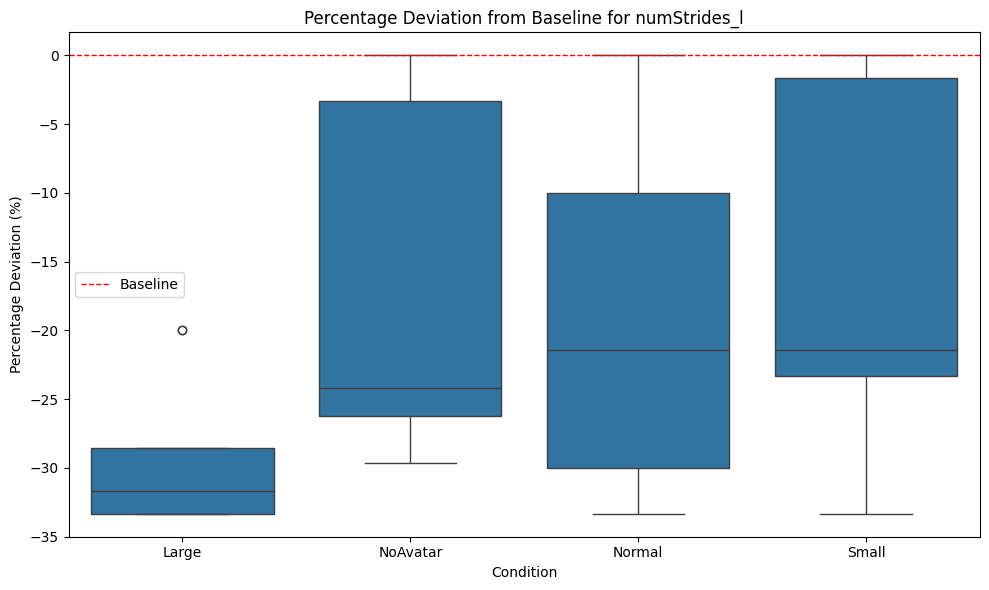

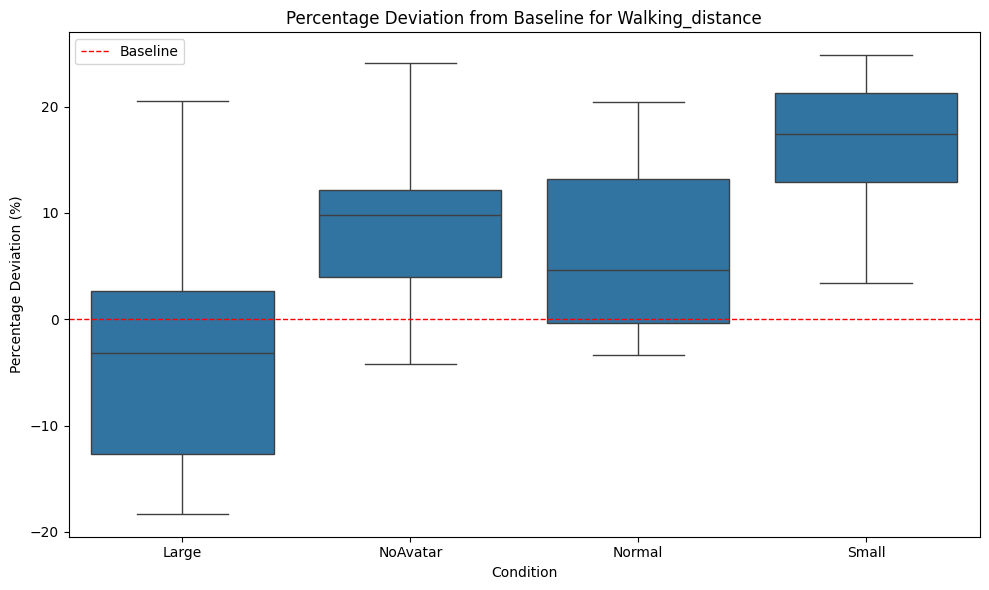

In [51]:
condition_names2 = {
    2: 'Large',
    3: 'NoAvatar',
    4: 'Normal',
    5: 'Small'
}
for param, deviation_df in percentage_deviation_results.items():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=deviation_df, x='Condition', y='Percentage Deviation')
    plt.title(f"Percentage Deviation from Baseline for {param}")
    plt.xlabel("Condition")
    plt.ylabel("Percentage Deviation (%)")
    unique_conditions = sorted(deviation_df['Condition'].unique())
    plt.xticks(ticks=range(len(unique_conditions)), labels=[condition_names2[cond] for cond in unique_conditions])
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label="Baseline")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
#Velocity-Daten nach Condition gruppieren
grouped_data = [df[df["Condition"] == condition]["Velocity"] for condition in df["Condition"].unique()]

# Kruskal-Wallis-Test
stat, p_value = stats.kruskal(*grouped_data)

print("Kruskal-Wallis-Test:")
print(f"Teststatistik = {stat}")
print(f"p-Wert = {p_value}")
 #Interpretation
if p_value > 0.05:
    print("Keine signifikanten Unterschiede zwischen den Bedingungen (Nullhypothese nicht abgelehnt).")
else:
    print("Signifikante Unterschiede zwischen den Bedingungen (Nullhypothese abgelehnt).")

Kruskal-Wallis-Test:
Teststatistik = 65.2510494159701
p-Wert = 2.2781573660560515e-13
Signifikante Unterschiede zwischen den Bedingungen (Nullhypothese abgelehnt).


In [45]:
# Paarweise Vergleiche
conditions = df["Condition"].unique()
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        group1 = df[df["Condition"] == conditions[i]]["Velocity"]
        group2 = df[df["Condition"] == conditions[j]]["Velocity"]
        
        # Mann-Whitney-U-Test
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        
        print(f"Mann-Whitney-U-Test zwischen {condition_names[i]} und {condition_names[j]}:")
        print(f"Teststatistik = {stat}, p-Wert = {p_value}")

Mann-Whitney-U-Test zwischen Baseline und Large:
Teststatistik = 4401.0, p-Wert = 3.5422033490672324e-14
Mann-Whitney-U-Test zwischen Baseline und NoAvatar:
Teststatistik = 3857.0, p-Wert = 2.7946294980165866e-08
Mann-Whitney-U-Test zwischen Baseline und Normal:
Teststatistik = 3780.0, p-Wert = 3.3781923728382605e-07
Mann-Whitney-U-Test zwischen Baseline und Small:
Teststatistik = 3833.0, p-Wert = 4.832786018566112e-08
Mann-Whitney-U-Test zwischen Large und NoAvatar:
Teststatistik = 3382.0, p-Wert = 0.00011389002741638349
Mann-Whitney-U-Test zwischen Large und Normal:
Teststatistik = 3705.0, p-Wert = 0.0015617007913756235
Mann-Whitney-U-Test zwischen Large und Small:
Teststatistik = 3528.0, p-Wert = 0.00046614718600618776
Mann-Whitney-U-Test zwischen NoAvatar und Normal:
Teststatistik = 5350.0, p-Wert = 0.3253609170192834
Mann-Whitney-U-Test zwischen NoAvatar und Small:
Teststatistik = 5060.0, p-Wert = 0.693293045207369
Mann-Whitney-U-Test zwischen Normal und Small:
Teststatistik = 469

In [6]:
velocity_stats = df.groupby(['Participant', 'Condition'])['Velocity'].agg(['mean', 'std', 'count'])
print(velocity_stats)

                           mean       std  count
Participant Condition                           
8           1          0.644262  0.036369      5
            2          0.544820  0.121430     10
            3          0.739627  0.123539     10
            4          0.529433  0.084942     10
            5          0.639228  0.148184     10
9           1          0.720868  0.017441      5
            2          0.473787  0.078976     10
            3          0.528346  0.063691     10
            4          0.473271  0.075333     10
            5          0.551284  0.151669     10
10          1          0.583227  0.034586      5
            2          0.503700  0.095111     10
            3          0.563549  0.094731     10
            4          0.562166  0.093998     10
            5          0.438798  0.068421     10
11          1          0.631713  0.043006      5
            2          0.595831  0.104664     10
            3          0.465722  0.046259     10
            4       

C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_25048\651046115.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  velocity_stats = df.groupby(['Participant', 'Condition'])['Velocity'].agg(['mean', 'std', 'count'])


In [5]:
# Berechne den Mittelwert von strideLength_l und strideLength_r als Gesamtmaß
df["stride_mean"] = (df['strideLength_l'] + df['strideLength_r']) / 2

In [10]:
conditions = pd.Categorical(df['Condition']).codes
# Test auf Normalverteilung für jede Bedingung
print("Test auf Normalverteilung (Shapiro-Wilk):")
for condition in np.unique(conditions):
    stat, p = stats.shapiro(df["Velocity"][conditions == condition])
    print(f"Bedingung {condition} for velocity: W-Statistik = {stat:.3f}, p-Wert = {p:.3f}")
    print("Test auf Normalverteilung (Shapiro-Wilk):")
for condition in np.unique(conditions):
    stat, p = stats.shapiro(df["strideLength_l"][conditions == condition])
    print(f"Bedingung {condition} for strideLength_l: W-Statistik = {stat:.3f}, p-Wert = {p:.3f}")
    print("Test auf Normalverteilung (Shapiro-Wilk):")
for condition in np.unique(conditions):
    stat, p = stats.shapiro(df["strideLength_r"][conditions == condition])
    print(f"Bedingung {condition} for strideLength_r: W-Statistik = {stat:.3f}, p-Wert = {p:.3f}")

Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 0 for velocity: W-Statistik = 0.988, p-Wert = 0.873
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 1 for velocity: W-Statistik = 0.929, p-Wert = 0.000
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 2 for velocity: W-Statistik = 0.940, p-Wert = 0.000
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 3 for velocity: W-Statistik = 0.919, p-Wert = 0.000
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 4 for velocity: W-Statistik = 0.926, p-Wert = 0.000
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 0 for strideLength_l: W-Statistik = 0.955, p-Wert = 0.057
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 1 for strideLength_l: W-Statistik = 0.982, p-Wert = 0.200
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 2 for strideLength_l: W-Statistik = 0.982, p-Wert = 0.181
Test auf Normalverteilung (Shapiro-Wilk):
Bedingung 3 for strideLength_l: W-Statistik = 0.965, p-Wert = 0.010
Test auf Normalverteilung (Shapiro-Wilk)

Kruskal-Wallis Test Results for RoM_knee_r :
   H-statistic       p-value
2    42.981434  5.526182e-11
3    39.585355  3.140294e-10
4    34.660562  3.925031e-09
5    55.033469  1.184947e-13


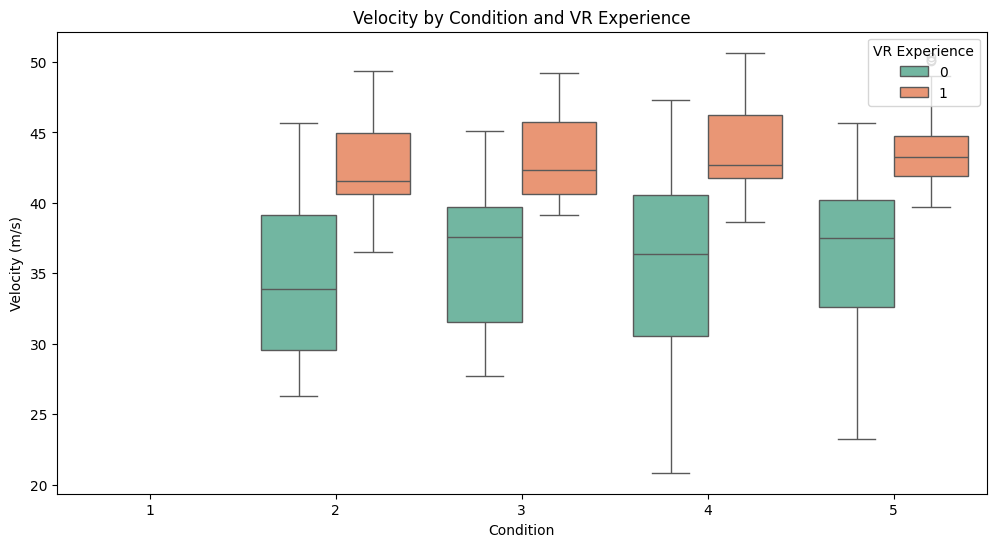

In [25]:
# Filter for VR conditions only (exclude baseline, Condition 1)
vr_conditions = df[df['Condition'] != 1]

# Define a function for Kruskal-Wallis test by VR-Experience for each condition
def kruskal_test_by_condition(df1, variable):
    results = {}
    for condition in sorted(df1['Condition'].unique()):
        group_data = df1[df1['Condition'] == condition]
        # Split data by VR-Experience
        vr_experience_groups = [group_data[group_data['VR_Experience'] == vr][variable] for vr in group_data['VR_Experience'].unique()]
        # Perform Kruskal-Wallis Test
        stat, p = stats.kruskal(*vr_experience_groups)
        results[condition] = {'H-statistic': stat, 'p-value': p}
    return pd.DataFrame(results).T

# Perform Kruskal-Wallis test for Velocity
kruskal_results_velocity = kruskal_test_by_condition(vr_conditions, 'RoM_knee_r')

# Print results
print("Kruskal-Wallis Test Results for RoM_knee_r :")
print(kruskal_results_velocity)

# Visualize the data using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=vr_conditions, x='Condition', y='RoM_knee_r', hue='VR_Experience', palette='Set2')
plt.title('Velocity by Condition and VR Experience')
plt.xlabel('Condition')
plt.ylabel('Velocity (m/s)')
plt.legend(title='VR Experience', loc='upper right')
plt.show()

In [31]:
test_parameters = [
    'Velocity', 'strideLength_l', 'strideLength_r',"stride_mean" ,'RoM_ankle_l', 'RoM_knee_l',
    'RoM_ankle_r', 'RoM_knee_r', 'numStrides_r', 'numStrides_l', 'Walking_distance'
]
embodiment_variables = ['Ownership', 'Agency', 'Change', 'Embodiment']
df['Embodiment'] = df[['Ownership', 'Agency', 'Change']].mean(axis=1)
# Calculate correlations
correlation_results = {}
for gait_param in test_parameters:
    for emb_var in embodiment_variables:
        corr, p_value = stats.spearmanr(df[emb_var], df[gait_param], nan_policy='omit')
        correlation_results[(emb_var, gait_param)] = {'Spearman Correlation': corr, 'p-value': p_value}

# Convert results to a DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df.index = pd.MultiIndex.from_tuples(correlation_df.index, names=['Embodiment Variable', 'Gait Parameter'])

# Print correlation results
print("Correlation Results between Embodiment and Gait Parameters:")
print(correlation_df)

Correlation Results between Embodiment and Gait Parameters:
                                      Spearman Correlation       p-value
Embodiment Variable Gait Parameter                                      
Ownership           Velocity                      0.071869  1.523972e-01
Agency              Velocity                      0.040436  4.211212e-01
Change              Velocity                     -0.110598  2.736601e-02
Embodiment          Velocity                      0.039539  4.315045e-01
Ownership           strideLength_l               -0.150286  2.648421e-03
Agency              strideLength_l               -0.025010  6.188715e-01
Change              strideLength_l                0.082502  1.002736e-01
Embodiment          strideLength_l               -0.026635  5.962552e-01
Ownership           strideLength_r                0.162208  1.164675e-03
Agency              strideLength_r                0.106813  3.314629e-02
Change              strideLength_r                0.063134  2.08

In [32]:
# Analyze Presence effect on deviations from Baseline
def calculate_deviations_from_baseline(df1, parameters):
    deviations = []
    for participant in df1['Participant'].unique():
        baseline = df1[(df1['Participant'] == participant) & (df1['Condition'] == 1)]
        vr_data = df1[(df1['Participant'] == participant) & (df1['Condition'] != 1)]
        if not baseline.empty:
            baseline_means = baseline[parameters].mean()
            for _, row in vr_data.iterrows():
                deviation = row[parameters] - baseline_means
                deviation['Participant'] = participant
                deviation['Condition'] = row['Condition']
                deviation['Presence'] = row['Presence']
                deviations.append(deviation)
    return pd.DataFrame(deviations)

# Calculate deviations
deviations = calculate_deviations_from_baseline(df, test_parameters)

# Correlate deviations with Presence
presence_correlation_results = {}
for param in test_parameters:
    corr, p_value = stats.spearmanr(deviations['Presence'], deviations[param], nan_policy='omit')
    presence_correlation_results[param] = {'Spearman Correlation': corr, 'p-value': p_value}

# Convert results to a DataFrame
presence_correlation_df = pd.DataFrame.from_dict(presence_correlation_results, orient='index')

# Print correlation results
print("Correlation Results between Presence and Deviations from Baseline:")
print(presence_correlation_df)


Correlation Results between Presence and Deviations from Baseline:
                  Spearman Correlation       p-value
Velocity                     -0.053186  2.898428e-01
strideLength_l               -0.032520  5.176890e-01
strideLength_r                0.339702  3.310343e-12
stride_mean                   0.234694  2.204892e-06
RoM_ankle_l                  -0.167155  8.145027e-04
RoM_knee_l                   -0.392472  4.159784e-16
RoM_ankle_r                   0.191394  1.221018e-04
RoM_knee_r                    0.034518  4.922864e-01
numStrides_r                 -0.258757  1.646536e-07
numStrides_l                  0.276143  2.131446e-08
Walking_distance              0.503307  6.007886e-27


C:\Users\grego\AppData\Local\Temp\ipykernel_12908\1632224046.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Condition', y=param, palette='Set1', inner="quartile", ax = ax)
C:\Users\grego\AppData\Local\Temp\ipykernel_12908\1632224046.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Condition', y=param, palette='Set1', inner="quartile", ax = ax)
C:\Users\grego\AppData\Local\Temp\ipykernel_12908\1632224046.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Condition', y=param, palette='Se

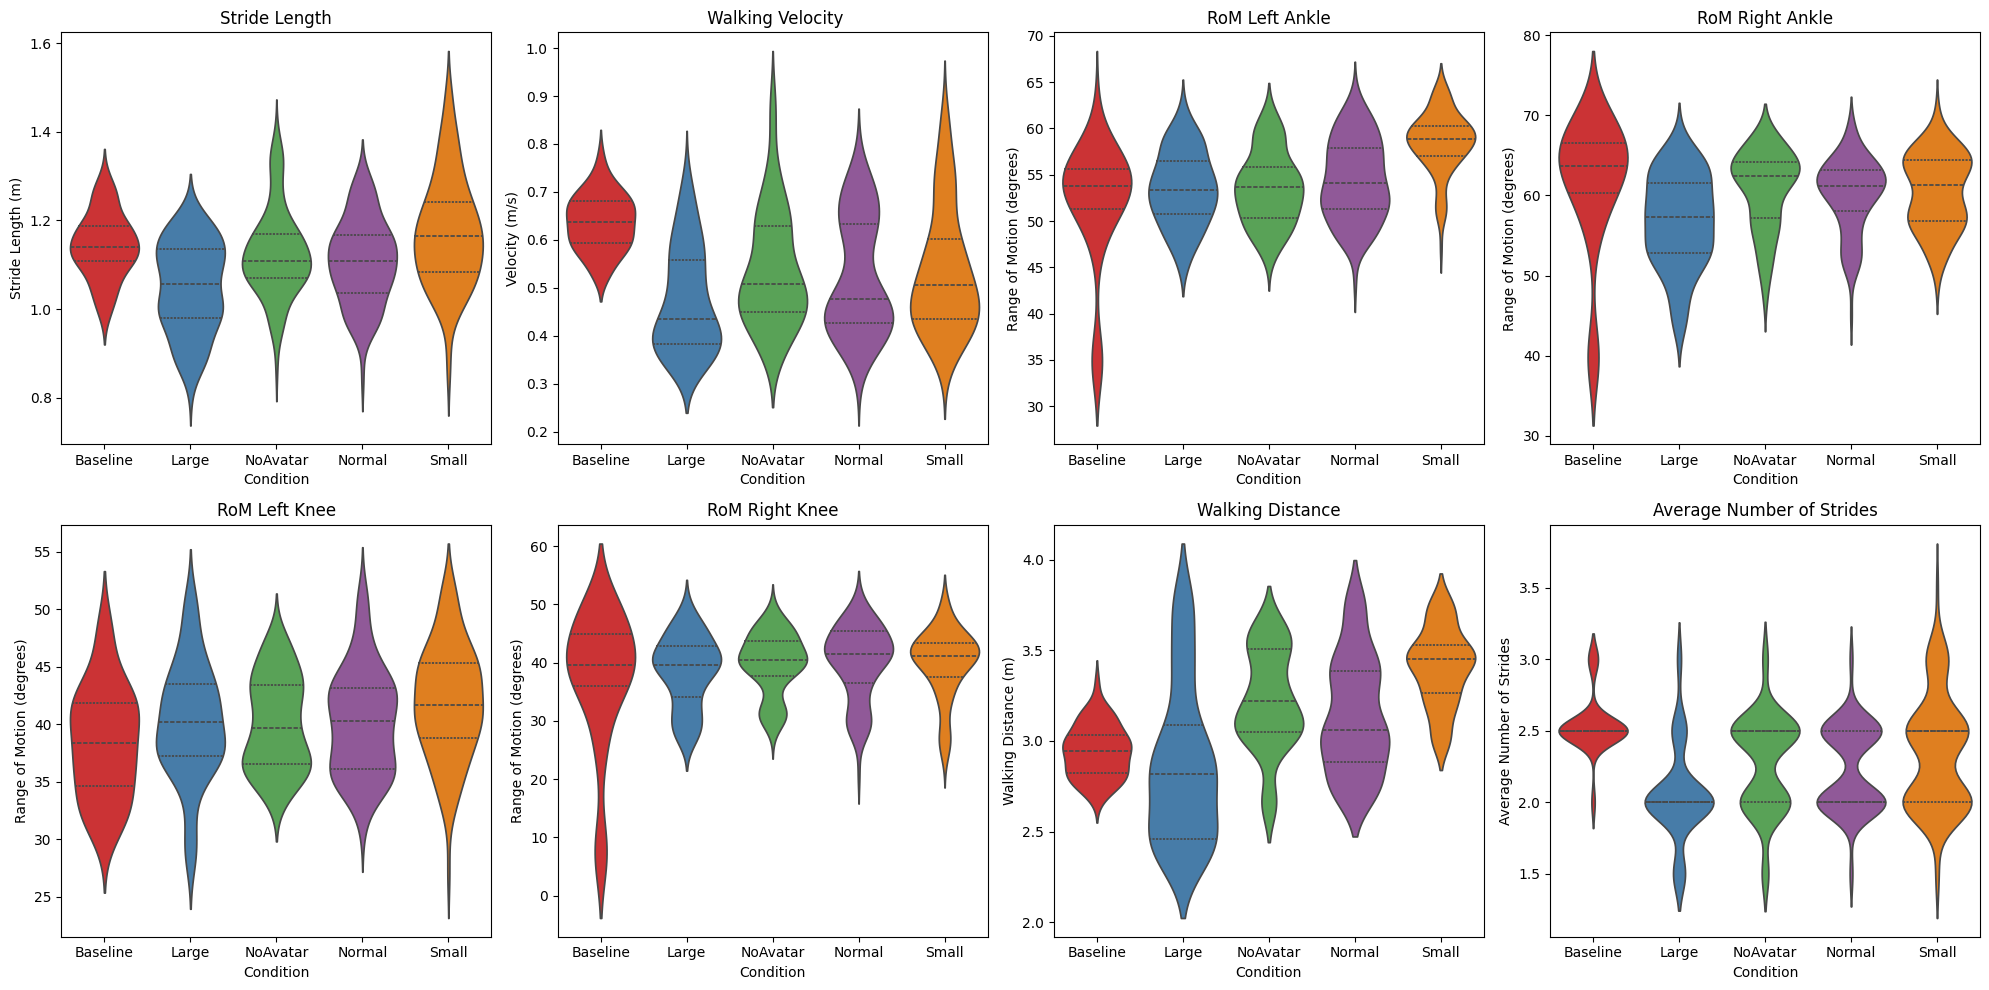

In [57]:
# Visualize Gait Parameters across Conditions
df["numStrides_avg"] = (df["numStrides_l"] +df["numStrides_r"])/2
unit_mapping = {
        'stride_mean': 'Stride Length (m)',
        'Velocity': 'Velocity (m/s)',
        'RoM_ankle_l': 'Range of Motion (degrees)',
        'RoM_ankle_r': 'Range of Motion (degrees)',
        'RoM_knee_l': 'Range of Motion (degrees)',
        'RoM_knee_r': 'Range of Motion (degrees)',
        'Walking_distance': 'Walking Distance (m)',
        'numStrides_avg': 'Average Number of Strides'}
titles ={
        'stride_mean': 'Stride Length',
        'Velocity': ' Walking Velocity',
        'RoM_ankle_l': 'RoM Left Ankle',
        'RoM_ankle_r': 'RoM Right Ankle',
        'RoM_knee_l': 'RoM Left Knee',
        'RoM_knee_r': 'RoM Right Knee',
        'Walking_distance': 'Walking Distance',
        'numStrides_avg': 'Average Number of Strides'}
def visualize_gait_parameters_across_conditions(df, parameters):
         
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
        axes = axes.flatten()
        for ax, param in zip(axes, parameters):
            sns.violinplot(data=df, x='Condition', y=param, palette='Set1', inner="quartile", ax = ax)
            ax.set_title(titles.get(param,param))
            ax.set_xticks(ticks=range(len(condition_names)), labels=condition_names)
            ax.set_xlabel('Condition')
            ax.set_ylabel(unit_mapping.get(param, param))
           
        plt.tight_layout()
        plt.show
# Gait parameters to visualize
parameters_to_visualize = ['stride_mean', 'Velocity', 'RoM_ankle_l', 'RoM_ankle_r', 'RoM_knee_l', 'RoM_knee_r', 'Walking_distance', 'numStrides_avg']
visualize_gait_parameters_across_conditions(df, parameters_to_visualize)

In [49]:

group_data = [df["stride_mean"][conditions == c] for c in np.unique(conditions)]
h_stat, p_val = stats.kruskal(*group_data)
print(f"H-Statistik: {h_stat:.3f}, p-Wert: {p_val}")


 # Post-hoc-Tests (paarweise Vergleiche mit Wilcoxon-Test)
dunn_results = posthoc_dunn([df["stride_mean"][conditions == c] for c in np.unique(conditions)], p_adjust='bonferroni')
dunn_results.index = condition_names
dunn_results.columns = condition_names
print(dunn_results)


IndexError: Boolean index has wrong length: 5 instead of 448

## Bayesian Model

In [ ]:
vr_conditions = [2, 3, 4, 5]
vr_data = df[df['Condition'].isin(vr_conditions)]

Participant Condition  Trial  Velocity  numStrides_r  numStrides_l  \
5             8         2      1  0.478001             2             2   
6             8         2      2  0.695933             2             2   
7             8         2      3  0.472291             2             2   
8             8         2      4  0.679479             2             2   
9             8         2      5  0.707910             2             2   
..          ...       ...    ...       ...           ...           ...   
443          17         5      6  0.698649             2             2   
444          17         5      7  0.440218             2             2   
445          17         5      8  0.462329             2             3   
446          17         5      9  0.445686             2             2   
447          17         5     10  0.814630             2             2   

     Walking_distance  HeelR_velocity  HeelL_velocity  strideLength_r  ...  \
5            2.905158        0.576114        0.584234        1.140597  ...   
6            2.905158        0.834845        0.845427        1.137764  ...   
7            2.905158        0.562454        0.578270        1.181936  ...   
8            2.905158        0.819656        0.829033        1.151913  ...   
9            2.905158        0.861433        0.854560        1.050367  ...   
..                ...             ...             ...             ...  ...   
443          3.454184        0.863424        0.928762        1.302671  ...   
444          3.454184        0.543209        0.545964        1.289659  ...   
445          3.454184        0.557847        1.168773        1.247844  ...   
446          3.454184        0.567553        0.543854        1.376918  ...   
447          3.454184        1.012262        1.362989        1.316416  ...   

     RoM_knee_r  Velocity_normalized  Height  Weight  Presence  VR_Experience  \
5     36.276808             0.287449    1.95      68  4.571429              0   
6     32.666978             0.658599    1.95      68  4.571429              0   
7     36.404693             0.277724    1.95      68  4.571429              0   
8     35.652710             0.630577    1.95      68  4.571429              0   
9     33.397493             0.678997    1.95      68  4.571429              0   
..          ...                  ...     ...     ...       ...            ...   
443   43.573658             0.663225    1.83      72  3.785714              1   
444   44.597032             0.223102    1.83      72  3.785714              1   
445   41.542159             0.260759    1.83      72  3.785714              1   
446   44.740287             0.232414    1.83      72  3.785714              1   
447   44.616119             0.860747    1.83      72  3.785714              1   

     Ownership  Agency  Change  Embdodiment  
5         1.50    4.75     5.0     3.750000  
6         1.50    4.75     5.0     3.750000  
7         1.50    4.75     5.0     3.750000  
8         1.50    4.75     5.0     3.750000  
9         1.50    4.75     5.0     3.750000  
..         ...     ...     ...          ...  
443       4.75    6.00     4.5     5.083333  
444       4.75    6.00     4.5     5.083333  
445       4.75    6.00     4.5     5.083333  
446       4.75    6.00     4.5     5.083333  
447       4.75    6.00     4.5     5.083333  

[398 rows x 24 columns]

In [47]:

modelf = bmb.Model("Velocity  ~  Condition + (1|Participant) ",data = df) # (1 | x) is a random intercept  + (1|Participant)  data= df[df["Condition"] != 1]
fittedf = modelf.fit( 
    draws=2000, 
    tune= 1000,
    # init="adapt_diag", 
    # random_seed=69,
    #cores=8,
    #chains=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 2021 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


<AxesSubplot: xlabel='Velocity'>

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


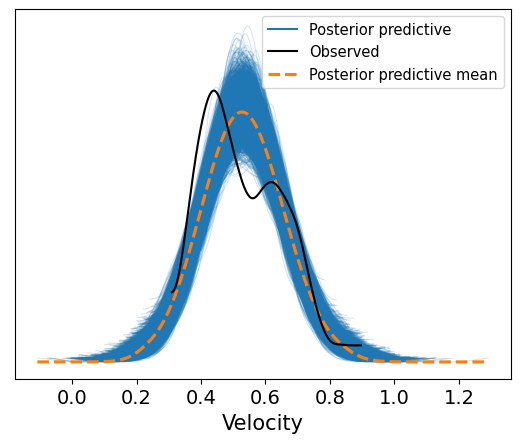

In [49]:
ppcf = modelf.predict(idata=fittedf, kind="pps", inplace=False)
az.plot_ppc(ppcf)

array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Condition\n2'}>,
        <AxesSubplot: title={'center': 'Condition\n3'}>],
       [<AxesSubplot: title={'center': 'Condition\n4'}>,
        <AxesSubplot: title={'center': 'Condition\n5'}>,
        <AxesSubplot: title={'center': '1|Participant_sigma'}>,
        <AxesSubplot: title={'center': '1|Participant\n8'}>],
       [<AxesSubplot: title={'center': '1|Participant\n9'}>,
        <AxesSubplot: title={'center': '1|Participant\n10'}>,
        <AxesSubplot: title={'center': '1|Participant\n11'}>,
        <AxesSubplot: title={'center': '1|Participant\n12'}>],
       [<AxesSubplot: title={'center': '1|Participant\n13'}>,
        <AxesSubplot: title={'center': '1|Participant\n14'}>,
        <AxesSubplot: title={'center': '1|Participant\n15'}>,
        <AxesSubplot: title={'center': '1|Participant\n16'}>],
       [<AxesSubplot: title={'center': '1|Pa

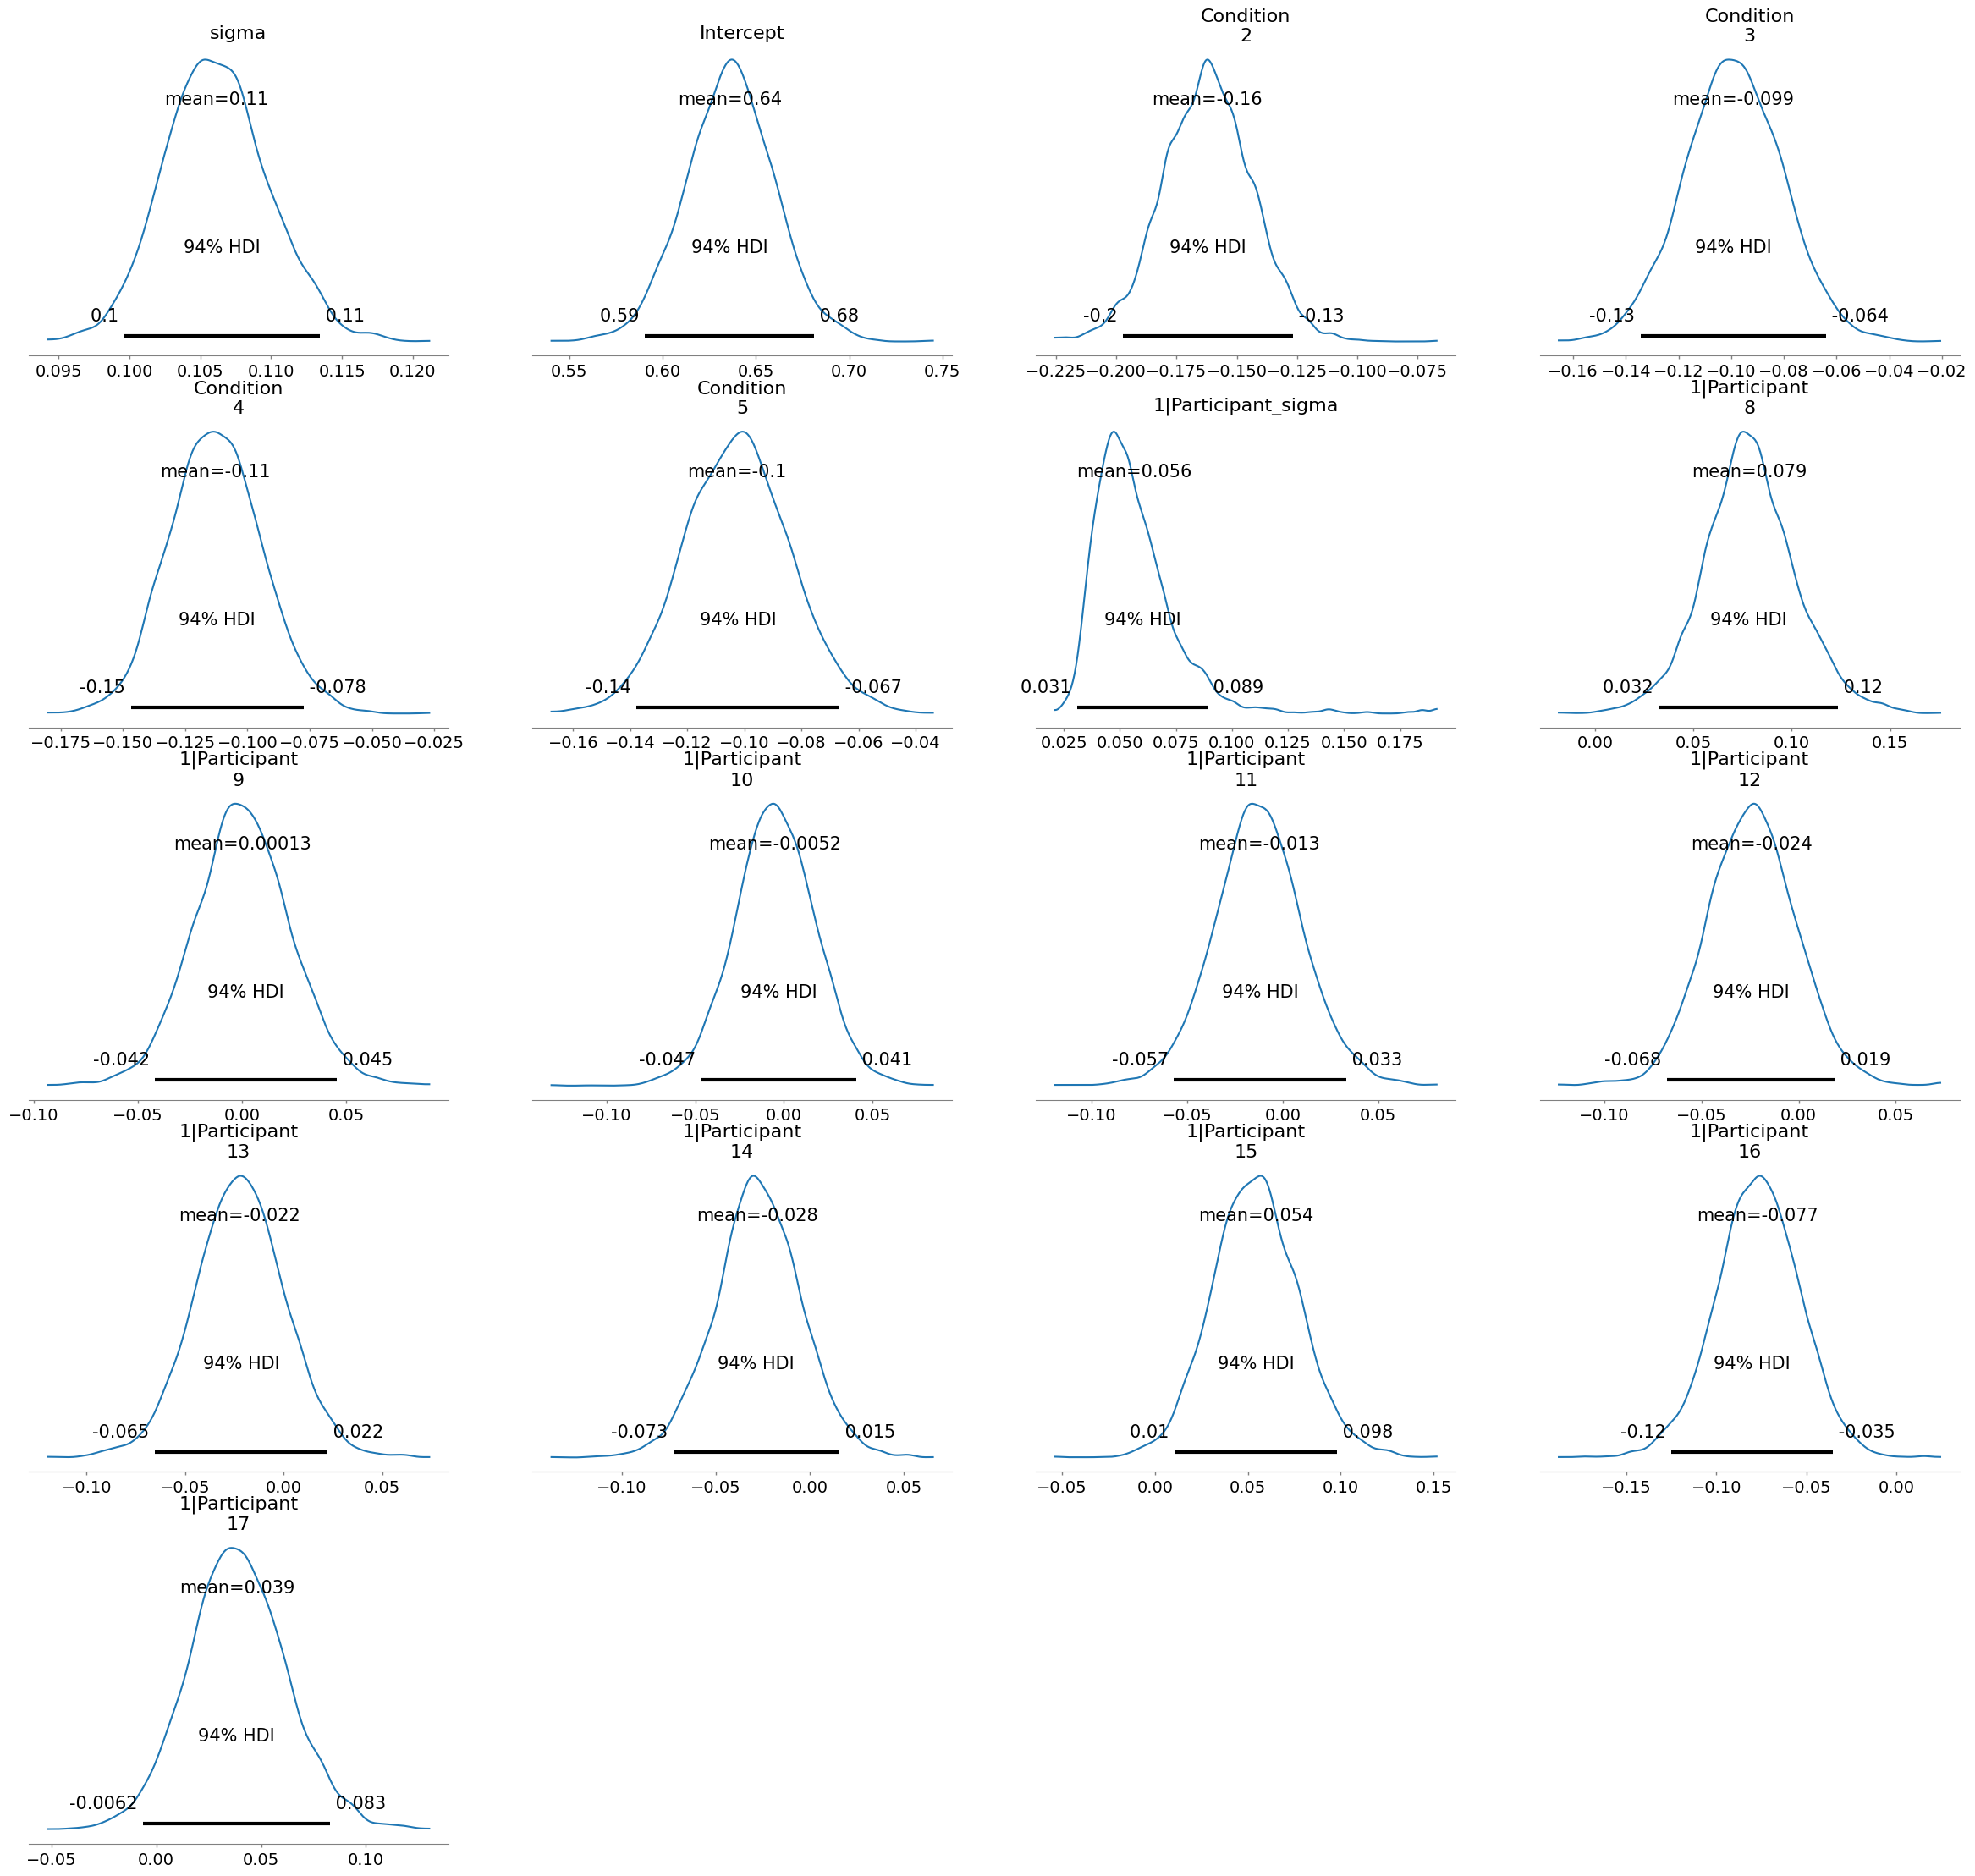

In [50]:
az.plot_posterior(fittedf)

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma              0.101  0.004   0.094    0.109      0.000    0.000   
Condition[2]       0.442  0.208   0.019    0.837      0.009    0.008   
Condition[3]       0.481  0.203   0.050    0.836      0.009    0.007   
Condition[4]       0.493  0.208   0.051    0.886      0.008    0.006   
Condition[5]       0.445  0.217   0.067    0.957      0.013    0.012   
...                  ...    ...     ...      ...        ...      ...   
1|Participant[13] -0.093  0.043  -0.175   -0.014      0.001    0.001   
1|Participant[14]  0.005  0.039  -0.069    0.079      0.001    0.000   
1|Participant[15]  0.092  0.033   0.029    0.153      0.001    0.000   
1|Participant[16] -0.077  0.038  -0.146   -0.004      0.001    0.001   
1|Participant[17]  0.055  0.034  -0.008    0.122      0.001    0.000   

                   ess_bulk  ess_tail  r_hat  
sigma                3061.0    1752.0   1.01  
Condition[2]          475.0    2245.0   1

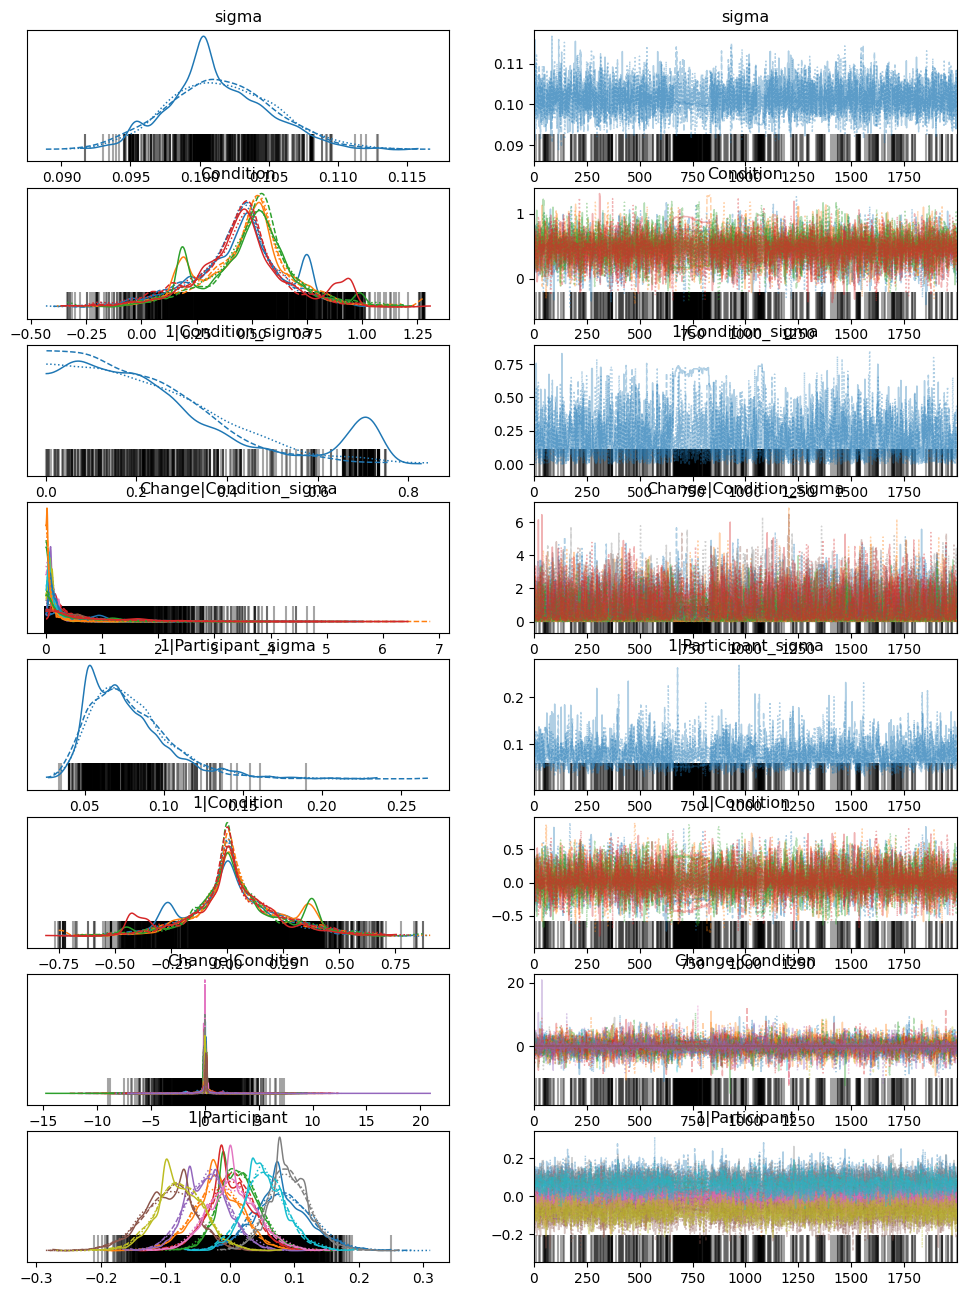

In [28]:

# Zusammenfassung der Posterior-Werte
print(az.summary(fitted))

# Posterior-Traces visualisieren
az.plot_trace(fitted)

# Diagnostik (Rhat-Werte überprüfen)
diagnostics = az.rhat(fitted)
print(diagnostics)

# Werte von Rhat sollten nahe 1 liegen (idealerweise < 1.05).


array([<AxesSubplot: title={'center': 'Condition\n2'}>,
       <AxesSubplot: title={'center': 'Condition\n3'}>,
       <AxesSubplot: title={'center': 'Condition\n4'}>,
       <AxesSubplot: title={'center': 'Condition\n5'}>], dtype=object)

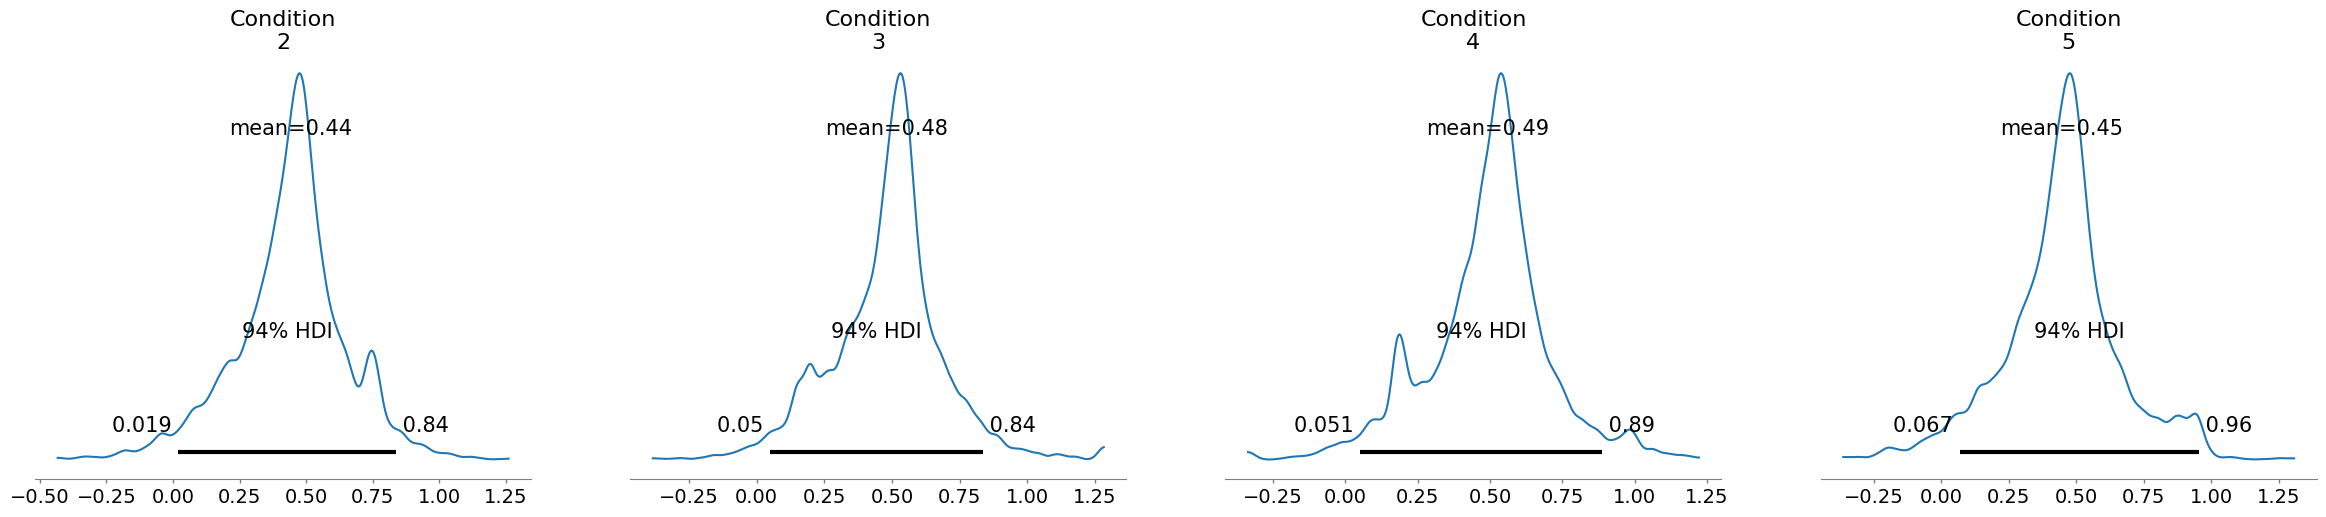

In [53]:
az.plot_posterior(fitted, var_names=["Condition"],)

In [33]:
ppc = model.predict(idata=fitted, kind="pps", inplace=False)


C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


In [31]:
print(ppc)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

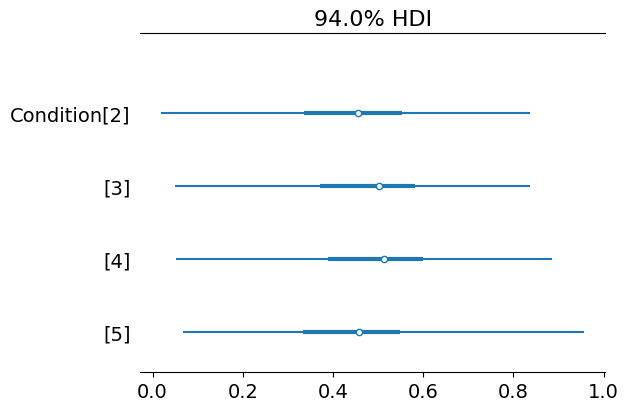

In [30]:

az.plot_forest(fitted, var_names=["Condition"], combined=True)

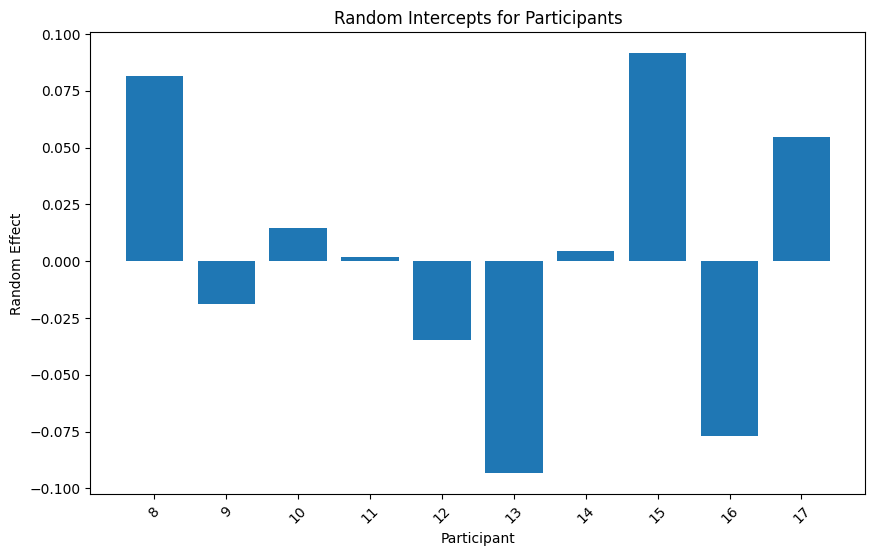

In [31]:
participant_effects = fitted.posterior["1|Participant"].mean(dim=["chain", "draw"])

# Konvertiere die Effekte in ein pandas DataFrame
participant_effects_df = pd.DataFrame({
    "Participant": participant_effects.Participant__factor_dim.values,
    "Effect": participant_effects.values
})

# Plot der zufälligen Effekte
plt.figure(figsize=(10, 6))
plt.bar(participant_effects_df["Participant"], participant_effects_df["Effect"])
plt.title("Random Intercepts for Participants")
plt.xlabel("Participant")
plt.ylabel("Random Effect")
plt.xticks(rotation=45)
plt.show()

<AxesSubplot: xlabel='Velocity'>

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


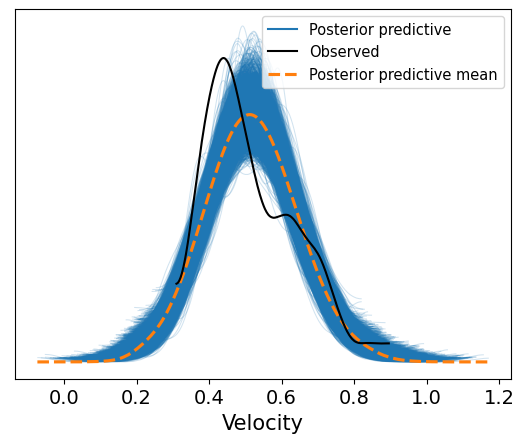

In [34]:
az.plot_ppc(ppc)

In [52]:

model_l = bmb.Model(
    "strideLength_l ~ Condition + Walking_distance + numStrides_l+ (1|Participant)", 
    data=df, 
    family="gaussian"
)

results_l = model_l.fit(draws=2000, tune=1000)

model_r = bmb.Model(
    "strideLength_r ~ Condition + Walking_distance + numStrides_r + (1|Participant)", 
    data=df, 
    family="gaussian"
)
results_r = model_r.fit(draws=2000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, Walking_distance, numStrides_l, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 3130 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, Walking_distance, numStrides_r, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 1_990 draw iterations (3_000 + 5_970 draws total) took 3416 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'Condition'}>,
        <AxesSubplot: title={'center': 'Condition'}>],
       [<AxesSubplot: title={'center': 'Walking_distance'}>,
        <AxesSubplot: title={'center': 'Walking_distance'}>],
       [<AxesSubplot: title={'center': 'numStrides_r'}>,
        <AxesSubplot: title={'center': 'numStrides_r'}>],
       [<AxesSubplot: title={'center': '1|Participant_sigma'}>,
        <AxesSubplot: title={'center': '1|Participant_sigma'}>],
       [<AxesSubplot: title={'center': '1|Participant'}>,
        <AxesSubplot: title={'center': '1|Participant'}>]], dtype=object)

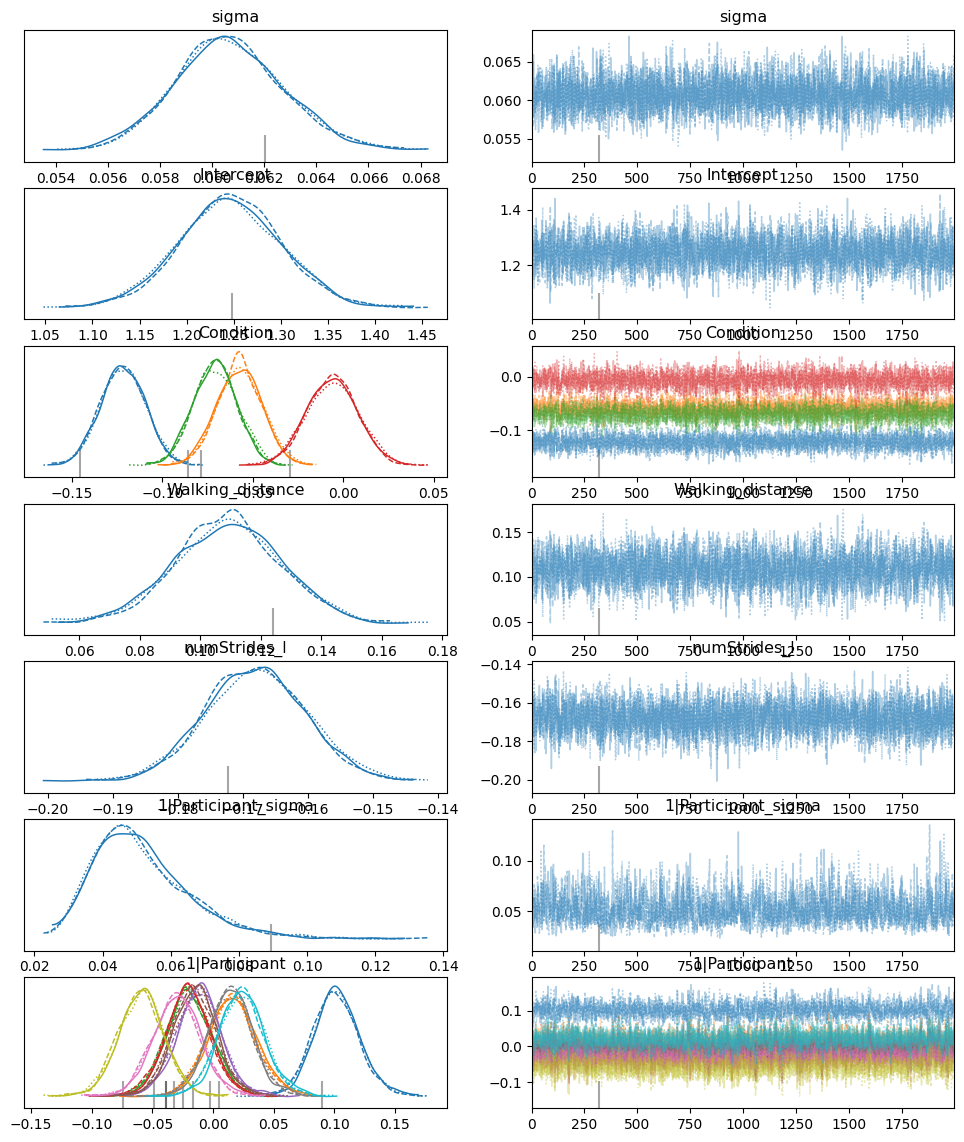

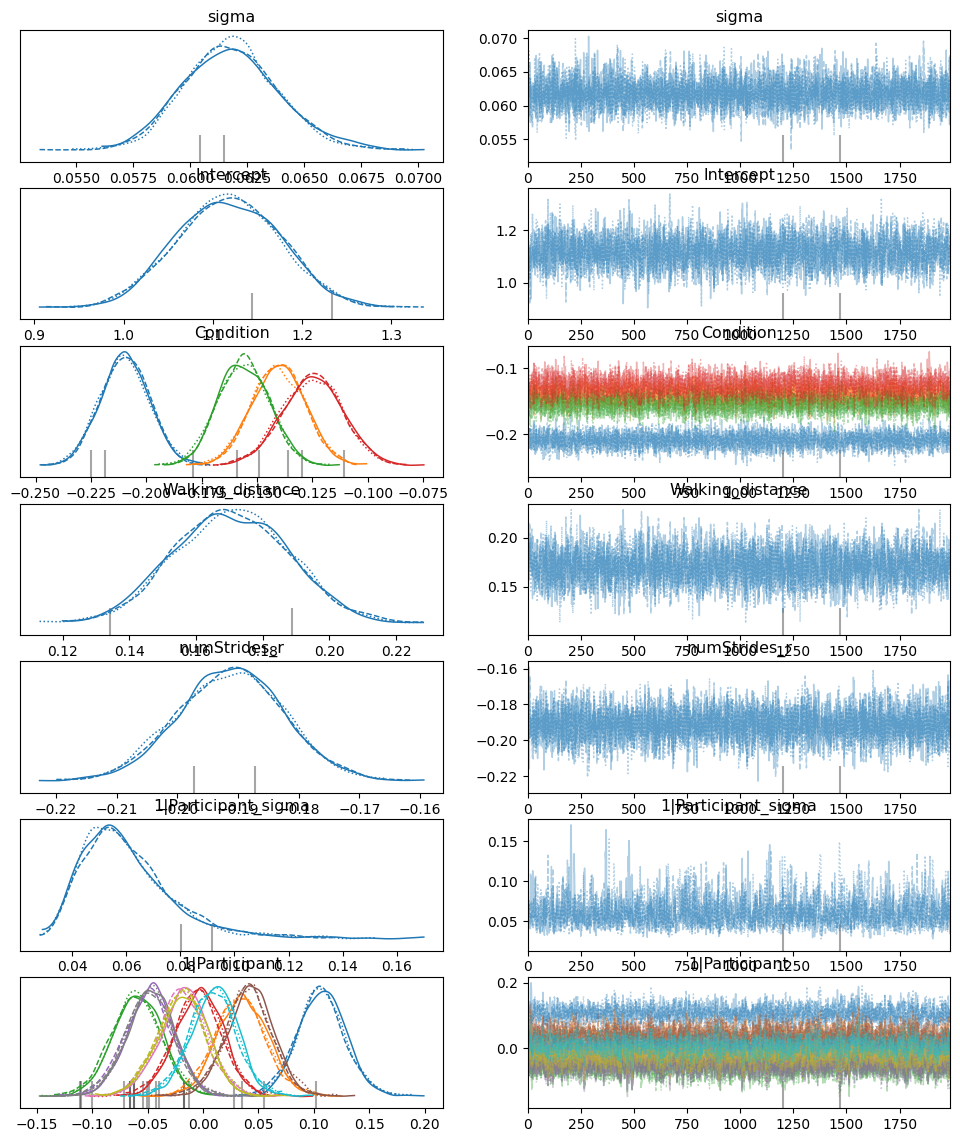

In [53]:
az.plot_trace(results_l)
az.plot_trace(results_r)

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


<AxesSubplot: xlabel='strideLength_l'>

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


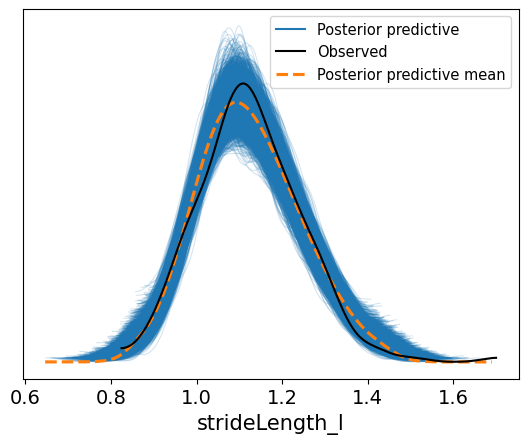

In [54]:
ppc_l = model_l.predict(idata=results_l, kind="pps", inplace=False)
az.plot_ppc(ppc_l)

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


<AxesSubplot: xlabel='strideLength_r'>

C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\grego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


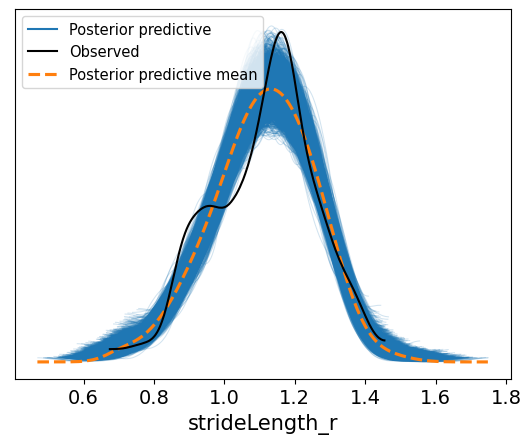

In [58]:
ppc_r = model_r.predict(idata=results_r, kind="pps", inplace=False)
az.plot_ppc(ppc_r)

In [64]:
condition_names2

['Large', 'NoAvatar', 'Normal', 'Small']

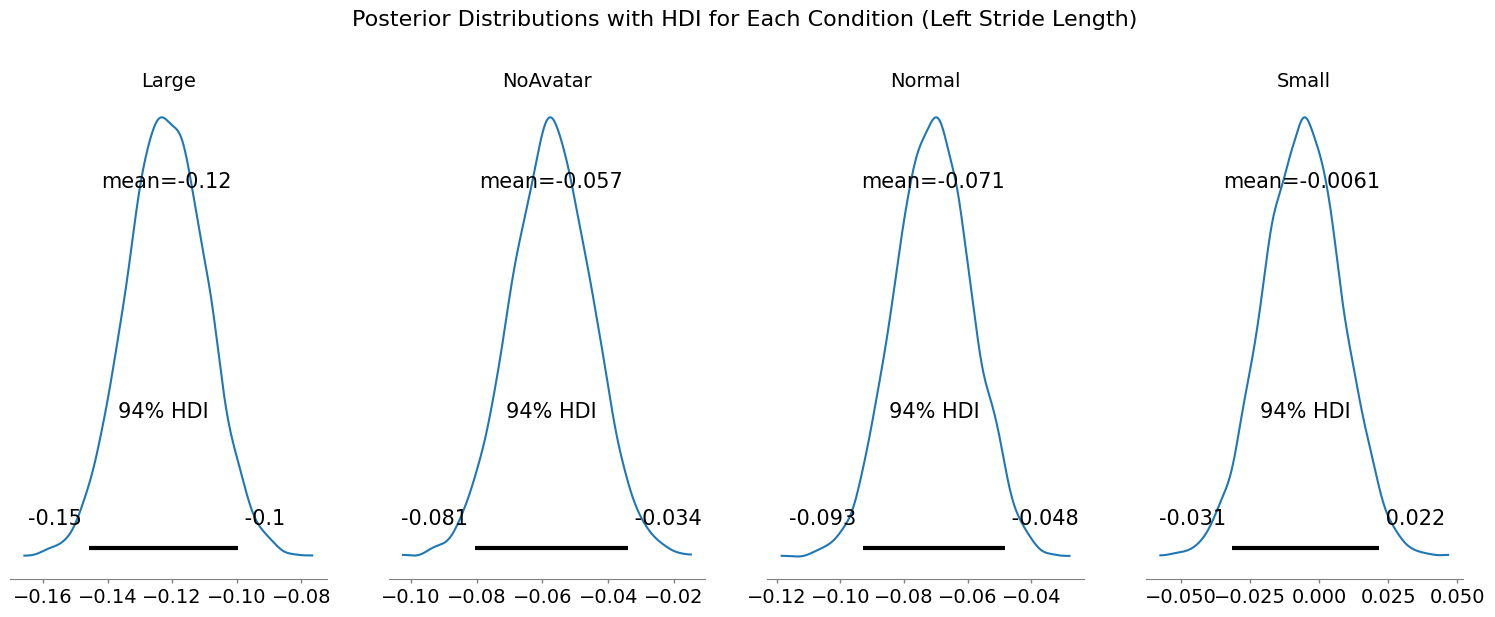

In [72]:
condition_names2 = condition_names[1:]

axes = az.plot_posterior(results_l, var_names=["Condition"], figsize = (15,6) )
for ax, name in zip(axes, condition_names2):
    ax.set_title(name, fontsize=14)

plt.suptitle("Posterior Distributions with HDI for Each Condition (Left Stride Length)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

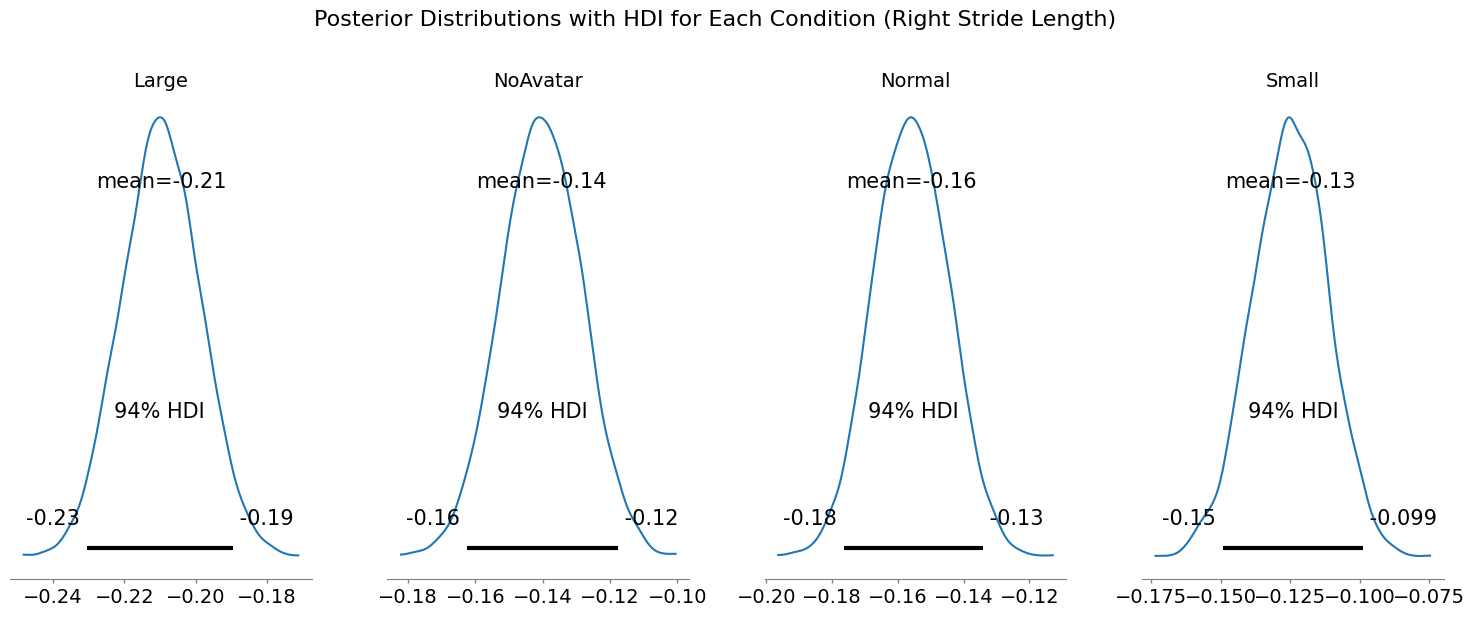

In [74]:
axes = az.plot_posterior(results_r, var_names=["Condition"], figsize = (15,6) )
for ax, name in zip(axes, condition_names2):
    ax.set_title(name, fontsize=14)

plt.suptitle("Posterior Distributions with HDI for Each Condition (Right Stride Length)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Walking_distance
Default computed for unspecified variable: Condition, Participant, numStrides_l


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='Walking_distance', ylabel='strideLength_l'>],
       dtype=object))

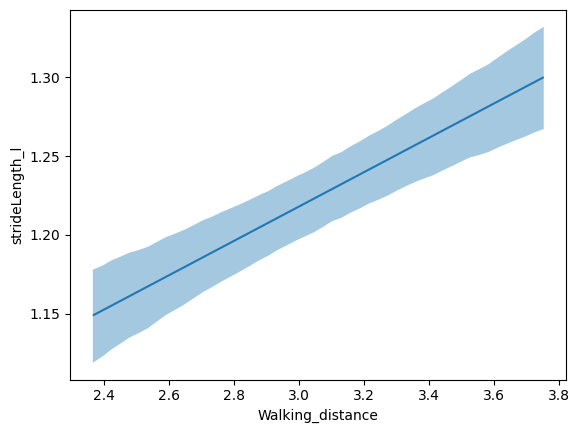

In [25]:
bmb.interpret.plot_predictions(model_l, results_l, "Walking_distance",group="C")

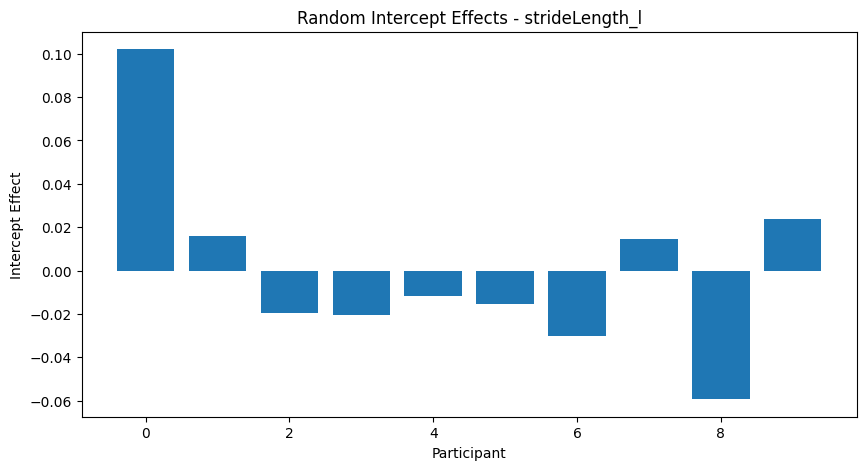

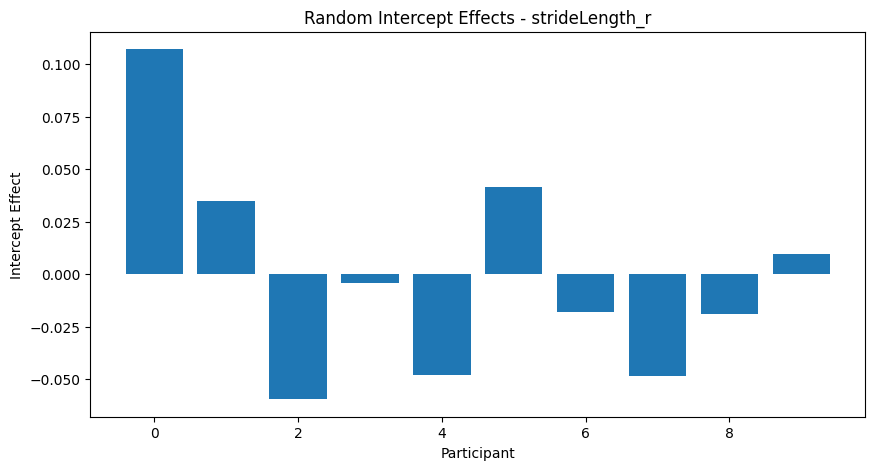

In [27]:
participant_effects_l = results_l.posterior["1|Participant"].mean(dim=["chain", "draw"])
participant_effects_r = results_r.posterior["1|Participant"].mean(dim=["chain", "draw"])

# Visualisierung der Random Effects für strideLength_l
plt.figure(figsize=(10, 5))
plt.bar(range(len(participant_effects_l)), participant_effects_l)
plt.title("Random Intercept Effects - strideLength_l")
plt.xlabel("Participant")
plt.ylabel("Intercept Effect")
plt.show()

# Visualisierung der Random Effects für strideLength_r
plt.figure(figsize=(10, 5))
plt.bar(range(len(participant_effects_r)), participant_effects_r)
plt.title("Random Intercept Effects - strideLength_r")
plt.xlabel("Participant")
plt.ylabel("Intercept Effect")
plt.show()